In [89]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import numpy as np
from scipy.spatial import distance
import warnings
warnings.filterwarnings("ignore")

In [90]:
class data_preparation:
  def prepare_data(self,path):
    df = pd.read_csv(path)
    cont = 0
    finestra = []

    for row in df.itertuples():
      
      if row[3] == 0:
        cont+=1
        finestra.append(0)
      else: 
        finestra.append(cont)
        cont = 0

    df["Finestra"] = finestra
    df.to_csv("finestra.csv")

    cont = 0

    for row in df.itertuples():
      if (row[3] == 1) & (row[4] != 0):

        # giorni normali precedenti più il giorno anomalo
        df_target = df.iloc[row[0] - row[4] : row[0] + 23]
        df_target.to_csv("dati" + str(cont) + ".csv")
        cont = cont + 1
    
    return cont

Classe predittore: 
- predizione_ultima_giornata_non_anomala: 
prende come **input** una riga dal file dati_riorganizzati che rappresenta un dataframe nel nuovo formato composto da tutte le normali prima di un'unica giornata anomala e un contatore utile per salvare l'immagine di output. 
Come **output** fornisce il confronto visivo  e la cosine distance tra la predizione effettuata su tutte le giornati normali precedenti all'ultima (normale) e quest'ultima.

- predizione_giornata_anomala: stessi **input** del metodo predizione_ultima_giornata_non_anomala ma questa volta si shifta di una giornata, non considerando quindi la prima giornata normala e includendo l'ultima giornata normale. L'**output** è un confronto visivo e la cosine distance tra la predizione e la giornata anomala.


In [91]:
class data_prediction:

  def __init__(self,path):
    self.path = path
    self.cosine_distance = []
    self.index = []
    self.anomali = []
    
  def predizione_ultima_giornata_non_anomala(self, dato, cont):

    # per predire ultima giornata non anomala uno i valori che vanno da 0 a [(indice_giorno_anomalo - 1) - 23]
    df_senza_anomalie = dato[dato["Anomalous"] == 0]
    df_target = df_senza_anomalie[0:-23] 
    df_da_predire = df_senza_anomalie[-23:]
    #df_da_predire.to_csv("dapredire.csv")
    #df_target.to_csv("target.csv")

    n_input = 23
    n_features = 1

    del df_target["Index"]
    del df_target["Anomalous"]
    del df_target["Finestra"]

    print(df_da_predire)

    train = df_target
    scaler = MinMaxScaler()
    scaler.fit(train)
    train = scaler.transform(train)

    # parametri: batch_size=32, epochs = 100
    generator = TimeseriesGenerator(train, train, length=n_input, batch_size=32)
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
    model.add(Dropout(0.15))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(generator, epochs=90)

    pred_list = []
    batch = train[-n_input:].reshape((1, n_input, n_features))

    for i in range(n_input):   
      pred_list.append(model.predict(batch)[0]) 
      batch = np.append(batch[:,1:,:],[[pred_list[i]]],axis=1)

    df_predict = pd.DataFrame(scaler.inverse_transform(pred_list), index=df_senza_anomalie[-n_input:].index, columns=['Prediction'])

    plt.figure(figsize=(40,20))
    plt.title("Confronto tra la giornata predetta e la giornata normale")
    plt.plot(df_predict.index, df_predict["Prediction"], color='r', marker="o")
    plt.plot(df_da_predire.index,df_da_predire["Affluenza"],color = "b",marker="o")
    plt.legend(loc='best', fontsize='small')
    plt.xticks(fontsize=6)
    plt.yticks(fontsize=18)
    plt.xticks(rotation=70)

    plt.savefig('confronto_normale' + str(cont) + '.png', bbox_inches='tight')

    print("Cosine distance: " + str(distance.cosine(df_predict["Prediction"],df_da_predire["Affluenza"])))
    self.index.append(df_da_predire["Index"].max())
    self.cosine_distance.append(distance.cosine(df_predict["Prediction"],df_da_predire["Affluenza"]))
    self.anomali.append(0)


  def predizione_giornata_anomala(self, dato, cont):
  
    # per predire la gioranta anomala dobbiamo prendere le giornate che vanno dalla seconda all'ultima normale
    df_senza_anomalie = dato[dato["Anomalous"] == 0]
    df_giornata_anomala = dato[dato["Anomalous"] == 1]

    # tolgo la prima giornata
    df_target = df_senza_anomalie[:23]

    df_da_predire = df_senza_anomalie.drop(df_target.index)
    # df_da_predire.to_csv("senza_anomalie.csv")
    
    n_input = 23
    n_features = 1

    del df_da_predire["Index"]
    del df_da_predire["Anomalous"]
    del df_da_predire["Finestra"]

    print(df_giornata_anomala)

    train = df_da_predire
    scaler = MinMaxScaler()
    scaler.fit(train)
    train = scaler.transform(train)

    # parametri: batch_size=32, epochs = 100
    generator = TimeseriesGenerator(train, train, length=n_input, batch_size=32)
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
    model.add(Dropout(0.15))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(generator, epochs=90)

    pred_list = []
    batch = train[-n_input:].reshape((1, n_input, n_features))

    for i in range(n_input):   
      pred_list.append(model.predict(batch)[0]) 
      batch = np.append(batch[:,1:,:],[[pred_list[i]]],axis=1)

    df_predict = pd.DataFrame(scaler.inverse_transform(pred_list), index=df_da_predire[-n_input:].index, columns=['Prediction'])

    plt.figure(figsize=(40,20))
    plt.title("Confronto tra la giornata predetta e la giornata anomala")
    plt.plot(df_giornata_anomala.index, df_predict["Prediction"], color='r', marker="o")
    plt.plot(df_giornata_anomala.index,df_giornata_anomala["Affluenza"],color = "b",marker="o")
    plt.legend(loc='best', fontsize='small')
    plt.xticks(fontsize=6)
    plt.yticks(fontsize=18)
    plt.xticks(rotation=70)

    plt.savefig('confronto_anomalia' + str(cont) + '.png', bbox_inches='tight')
    
    print("Cosine distance: " + str(distance.cosine(df_predict["Prediction"],df_giornata_anomala["Affluenza"])))
    self.index.append(df_giornata_anomala["Index"].max())
    self.cosine_distance.append(distance.cosine(df_predict["Prediction"],df_giornata_anomala["Affluenza"]))
    self.anomali.append(1)


In [96]:
class classifier:
  def classify_data(self,p):
    df = pd.DataFrame(p.cosine_distance,columns=["Cosine distance"],index=p.index)
    df["Anomali_reali"] = p.anomali

    X = df.index
    y = df["Cosine distance"]
    X, y = make_classification(random_state = 1,n_samples = 12)
    clf = MLPClassifier().fit(X, y)

    df["Anomali_predetti"] = clf.predict(X)
    print(clf.score(X, df["Anomali_reali"]))

    print(df)

Semplice main che scorre i dati e li passa, un valore alla volta, al predittore.

     Index  Affluenza  Anomalous  Finestra
551     25   0.259815          0         0
552     25   0.000859          0         0
553     25   0.000000          0         0
554     25   0.055599          0         0
555     25   0.320579          0         0
556     25   0.475891          0         0
557     25   0.483923          0         0
558     25   0.461801          0         0
559     25   0.449920          0         0
560     25   0.447341          0         0
561     25   0.466930          0         0
562     25   0.478542          0         0
563     25   0.446336          0         0
564     25   0.481498          0         0
565     25   0.361100          0         0
566     25   0.738049          0         0
567     25   0.832195          0         0
568     25   0.997685          0         0
569     25   1.000000          0         0
570     25   1.000000          0         0
571     25   1.000000          0         0
572     25   0.922061          0         0
573     25 

No handles with labels found to put in legend.


Cosine distance: 0.030396734185514585
     Index  Affluenza  Anomalous  Finestra
574     26   0.357869          1       230
575     26   0.165801          1         0
576     26   0.182777          1         0
577     26   0.175446          1         0
578     26   0.192533          1         0
579     26   0.000000          1         0
580     26   0.551561          1         0
581     26   0.565629          1         0
582     26   0.573039          1         0
583     26   0.706398          1         0
584     26   0.718703          1         0
585     26   0.718703          1         0
586     26   0.718703          1         0
587     26   0.668364          1         0
588     26   0.722959          1         0
589     26   0.885421          1         0
590     26   1.000000          1         0
591     26   1.000000          1         0
592     26   0.956821          1         0
593     26   0.827478          1         0
594     26   0.593696          1         0
595     26   0.4

No handles with labels found to put in legend.


Cosine distance: 0.07038596105478201
      Index  Affluenza  Anomalous  Finestra
1839     81   0.000000          0         0
1840     81   0.000000          0         0
1841     81   0.000929          0         0
1842     81   0.068813          0         0
1843     81   0.338152          0         0
1844     81   0.465299          0         0
1845     81   0.483688          0         0
1846     81   0.480450          0         0
1847     81   0.453639          0         0
1848     81   0.470577          0         0
1849     81   0.481427          0         0
1850     81   0.480975          0         0
1851     81   0.387325          0         0
1852     81   0.482230          0         0
1853     81   0.351672          0         0
1854     81   0.570941          0         0
1855     81   0.817655          0         0
1856     81   0.999981          0         0
1857     81   1.000000          0         0
1858     81   1.000000          0         0
1859     81   1.000000          0      

No handles with labels found to put in legend.


Cosine distance: 0.011989337485387885
      Index  Affluenza  Anomalous  Finestra
1862     82   0.377364          1      1265
1863     82   0.287481          1         0
1864     82   0.189347          1         0
1865     82   0.180733          1         0
1866     82   0.178080          1         0
1867     82   0.163378          1         0
1868     82   0.241715          1         0
1869     82   0.000000          1         0
1870     82   0.504268          1         0
1871     82   0.564126          1         0
1872     82   0.603767          1         0
1873     82   0.718703          1         0
1874     82   0.771265          1         0
1875     82   0.728904          1         0
1876     82   0.743257          1         0
1877     82   0.866500          1         0
1878     82   1.000000          1         0
1879     82   1.000000          1         0
1880     82   1.000000          1         0
1881     82   0.993220          1         0
1882     82   0.793555          1     

No handles with labels found to put in legend.


Cosine distance: 0.06939491025098599
      Index  Affluenza  Anomalous  Finestra
3219    141   0.132772          0         0
3220    141   0.000000          0         0
3221    141   0.002047          0         0
3222    141   0.059177          0         0
3223    141   0.314485          0         0
3224    141   0.480348          0         0
3225    141   0.480919          0         0
3226    141   0.473669          0         0
3227    141   0.465610          0         0
3228    141   0.476344          0         0
3229    141   0.483439          0         0
3230    141   0.485343          0         0
3231    141   0.484101          0         0
3232    141   0.436560          0         0
3233    141   0.449390          0         0
3234    141   0.700329          0         0
3235    141   0.908180          0         0
3236    141   1.000000          0         0
3237    141   1.000000          0         0
3238    141   1.000000          0         0
3239    141   1.000000          0      

No handles with labels found to put in legend.


Cosine distance: 0.01463735497243579
      Index  Affluenza  Anomalous  Finestra
3242    142   0.343492          1      1357
3243    142   0.000000          1         0
3244    142   0.204893          1         0
3245    142   0.176671          1         0
3246    142   0.165873          1         0
3247    142   0.166612          1         0
3248    142   0.287481          1         0
3249    142   0.562847          1         0
3250    142   0.516352          1         0
3251    142   0.566810          1         0
3252    142   0.585483          1         0
3253    142   0.718062          1         0
3254    142   0.734521          1         0
3255    142   0.730191          1         0
3256    142   0.762662          1         0
3257    142   0.965953          1         0
3258    142   1.000000          1         0
3259    142   1.000000          1         0
3260    142   1.000000          1         0
3261    142   0.988395          1         0
3262    142   0.757146          1      

No handles with labels found to put in legend.


Cosine distance: 0.03367526320339631
      Index  Affluenza  Anomalous  Finestra
3472    152   0.287481          0         0
3473    152   0.000000          0         0
3474    152   0.002847          0         0
3475    152   0.047708          0         0
3476    152   0.308051          0         0
3477    152   0.455802          0         0
3478    152   0.480341          0         0
3479    152   0.482247          0         0
3480    152   0.474029          0         0
3481    152   0.473960          0         0
3482    152   0.482326          0         0
3483    152   0.482725          0         0
3484    152   0.483948          0         0
3485    152   0.481918          0         0
3486    152   0.474112          0         0
3487    152   0.719457          0         0
3488    152   0.994398          0         0
3489    152   1.000000          0         0
3490    152   1.000000          0         0
3491    152   1.000000          0         0
3492    152   0.942953          0      

No handles with labels found to put in legend.


Cosine distance: 0.025027424002496357
      Index  Affluenza  Anomalous  Finestra
3495    153   0.133183          1       230
3496    153   0.180099          1         0
3497    153   0.176379          1         0
3498    153   0.212995          1         0
3499    153   0.000000          1         0
3500    153   0.574962          1         0
3501    153   0.546877          1         0
3502    153   0.571726          1         0
3503    153   0.554299          1         0
3504    153   0.548766          1         0
3505    153   0.568902          1         0
3506    153   0.569693          1         0
3507    153   0.533714          1         0
3508    153   0.569149          1         0
3509    153   0.545526          1         0
3510    153   0.767826          1         0
3511    153   0.862443          1         0
3512    153   0.999940          1         0
3513    153   1.000000          1         0
3514    153   1.000000          1         0
3515    153   1.000000          1     

No handles with labels found to put in legend.


Cosine distance: 0.029175284819783154
      Index  Affluenza  Anomalous  Finestra
4277    187   0.003421          0         0
4278    187   0.002931          0         0
4279    187   0.000000          0         0
4280    187   0.090843          0         0
4281    187   0.361245          0         0
4282    187   0.549179          0         0
4283    187   0.550135          0         0
4284    187   0.474120          0         0
4285    187   0.472447          0         0
4286    187   0.472127          0         0
4287    187   0.486299          0         0
4288    187   0.483818          0         0
4289    187   0.478649          0         0
4290    187   0.394676          0         0
4291    187   0.393106          0         0
4292    187   0.686039          0         0
4293    187   0.878586          0         0
4294    187   1.000000          0         0
4295    187   1.000000          0         0
4296    187   1.000000          0         0
4297    187   0.997360          0     

No handles with labels found to put in legend.


Cosine distance: 0.01738644261093869
      Index  Affluenza  Anomalous  Finestra
4300    188   0.132608          1       782
4301    188   0.000000          1         0
4302    188   0.010143          1         0
4303    188   0.108624          1         0
4304    188   0.594881          1         0
4305    188   0.831908          1         0
4306    188   0.875472          1         0
4307    188   0.703459          1         0
4308    188   0.660614          1         0
4309    188   0.709616          1         0
4310    188   0.811120          1         0
4311    188   0.831571          1         0
4312    188   0.770621          1         0
4313    188   0.741182          1         0
4314    188   0.726962          1         0
4315    188   0.979743          1         0
4316    188   1.000000          1         0
4317    188   1.000000          1         0
4318    188   1.000000          1         0
4319    188   1.000000          1         0
4320    188   1.000000          1      

No handles with labels found to put in legend.


Cosine distance: 0.03146442386111192
      Index  Affluenza  Anomalous  Finestra
4668    204   0.000000          0         0
4669    204   0.172944          0         0
4670    204   0.177097          0         0
4671    204   0.240296          0         0
4672    204   0.466097          0         0
4673    204   0.575581          0         0
4674    204   0.664625          0         0
4675    204   0.621608          0         0
4676    204   0.718703          0         0
4677    204   0.747497          0         0
4678    204   0.789076          0         0
4679    204   0.861494          0         0
4680    204   0.801977          0         0
4681    204   0.573647          0         0
4682    204   0.628412          0         0
4683    204   0.862443          0         0
4684    204   1.000000          0         0
4685    204   0.999360          0         0
4686    204   0.920837          0         0
4687    204   0.862443          0         0
4688    204   0.742926          0      

No handles with labels found to put in legend.


Cosine distance: 0.02081739337828148
      Index  Affluenza  Anomalous  Finestra
4691    205   0.000000          1       345
4692    205   0.009213          1         0
4693    205   0.000000          1         0
4694    205   0.076531          1         0
4695    205   0.311132          1         0
4696    205   0.440168          1         0
4697    205   0.503435          1         0
4698    205   0.659311          1         0
4699    205   0.811734          1         0
4700    205   0.977213          1         0
4701    205   0.999954          1         0
4702    205   1.000000          1         0
4703    205   1.000000          1         0
4704    205   0.894248          1         0
4705    205   0.852316          1         0
4706    205   0.999995          1         0
4707    205   1.000000          1         0
4708    205   0.991379          1         0
4709    205   0.833400          1         0
4710    205   0.820648          1         0
4711    205   0.768979          1      

No handles with labels found to put in legend.


Cosine distance: 0.0166822857686304


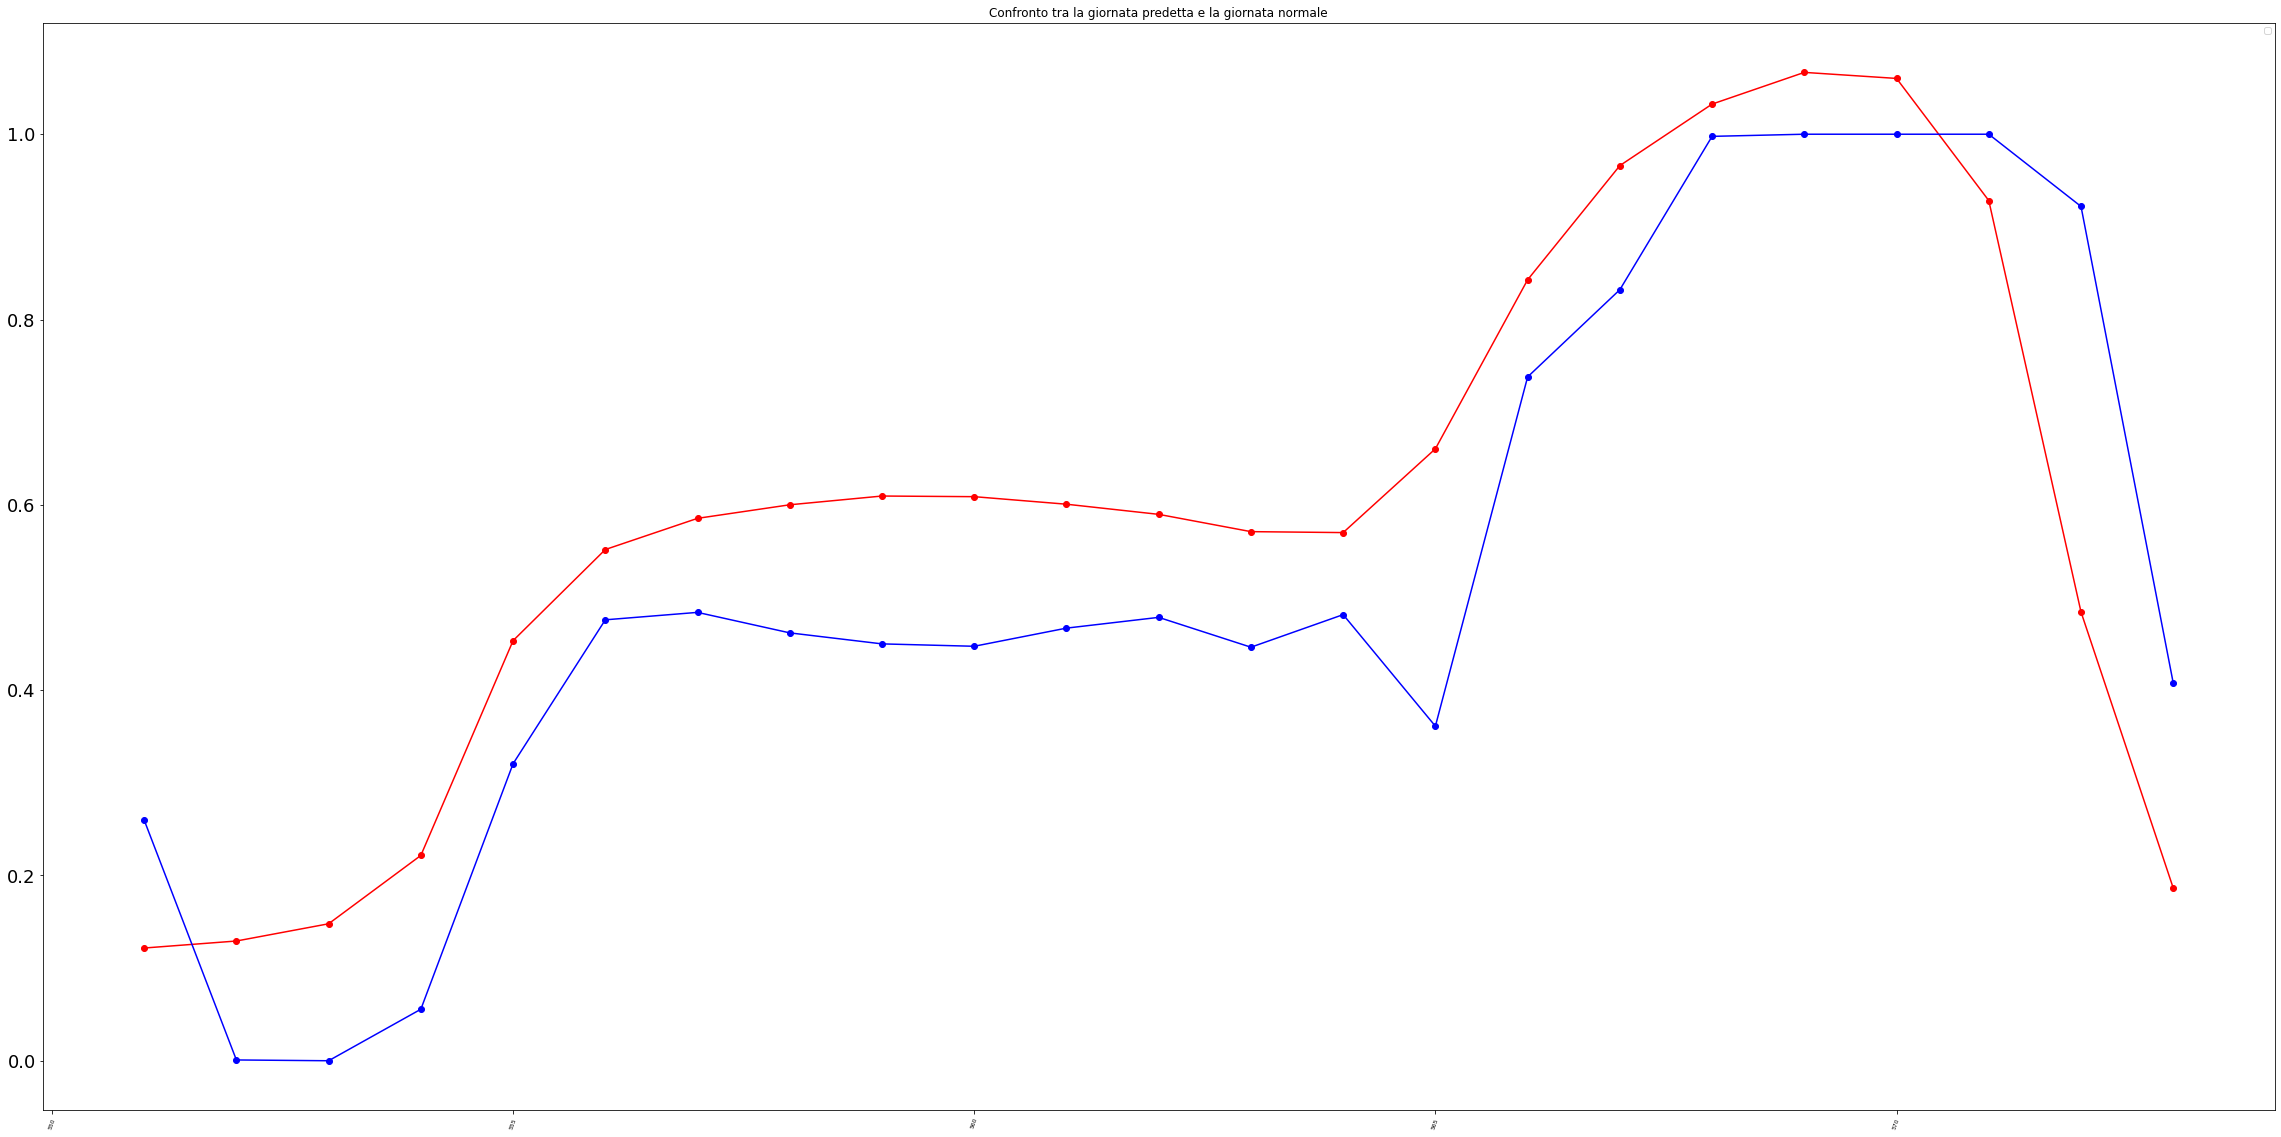

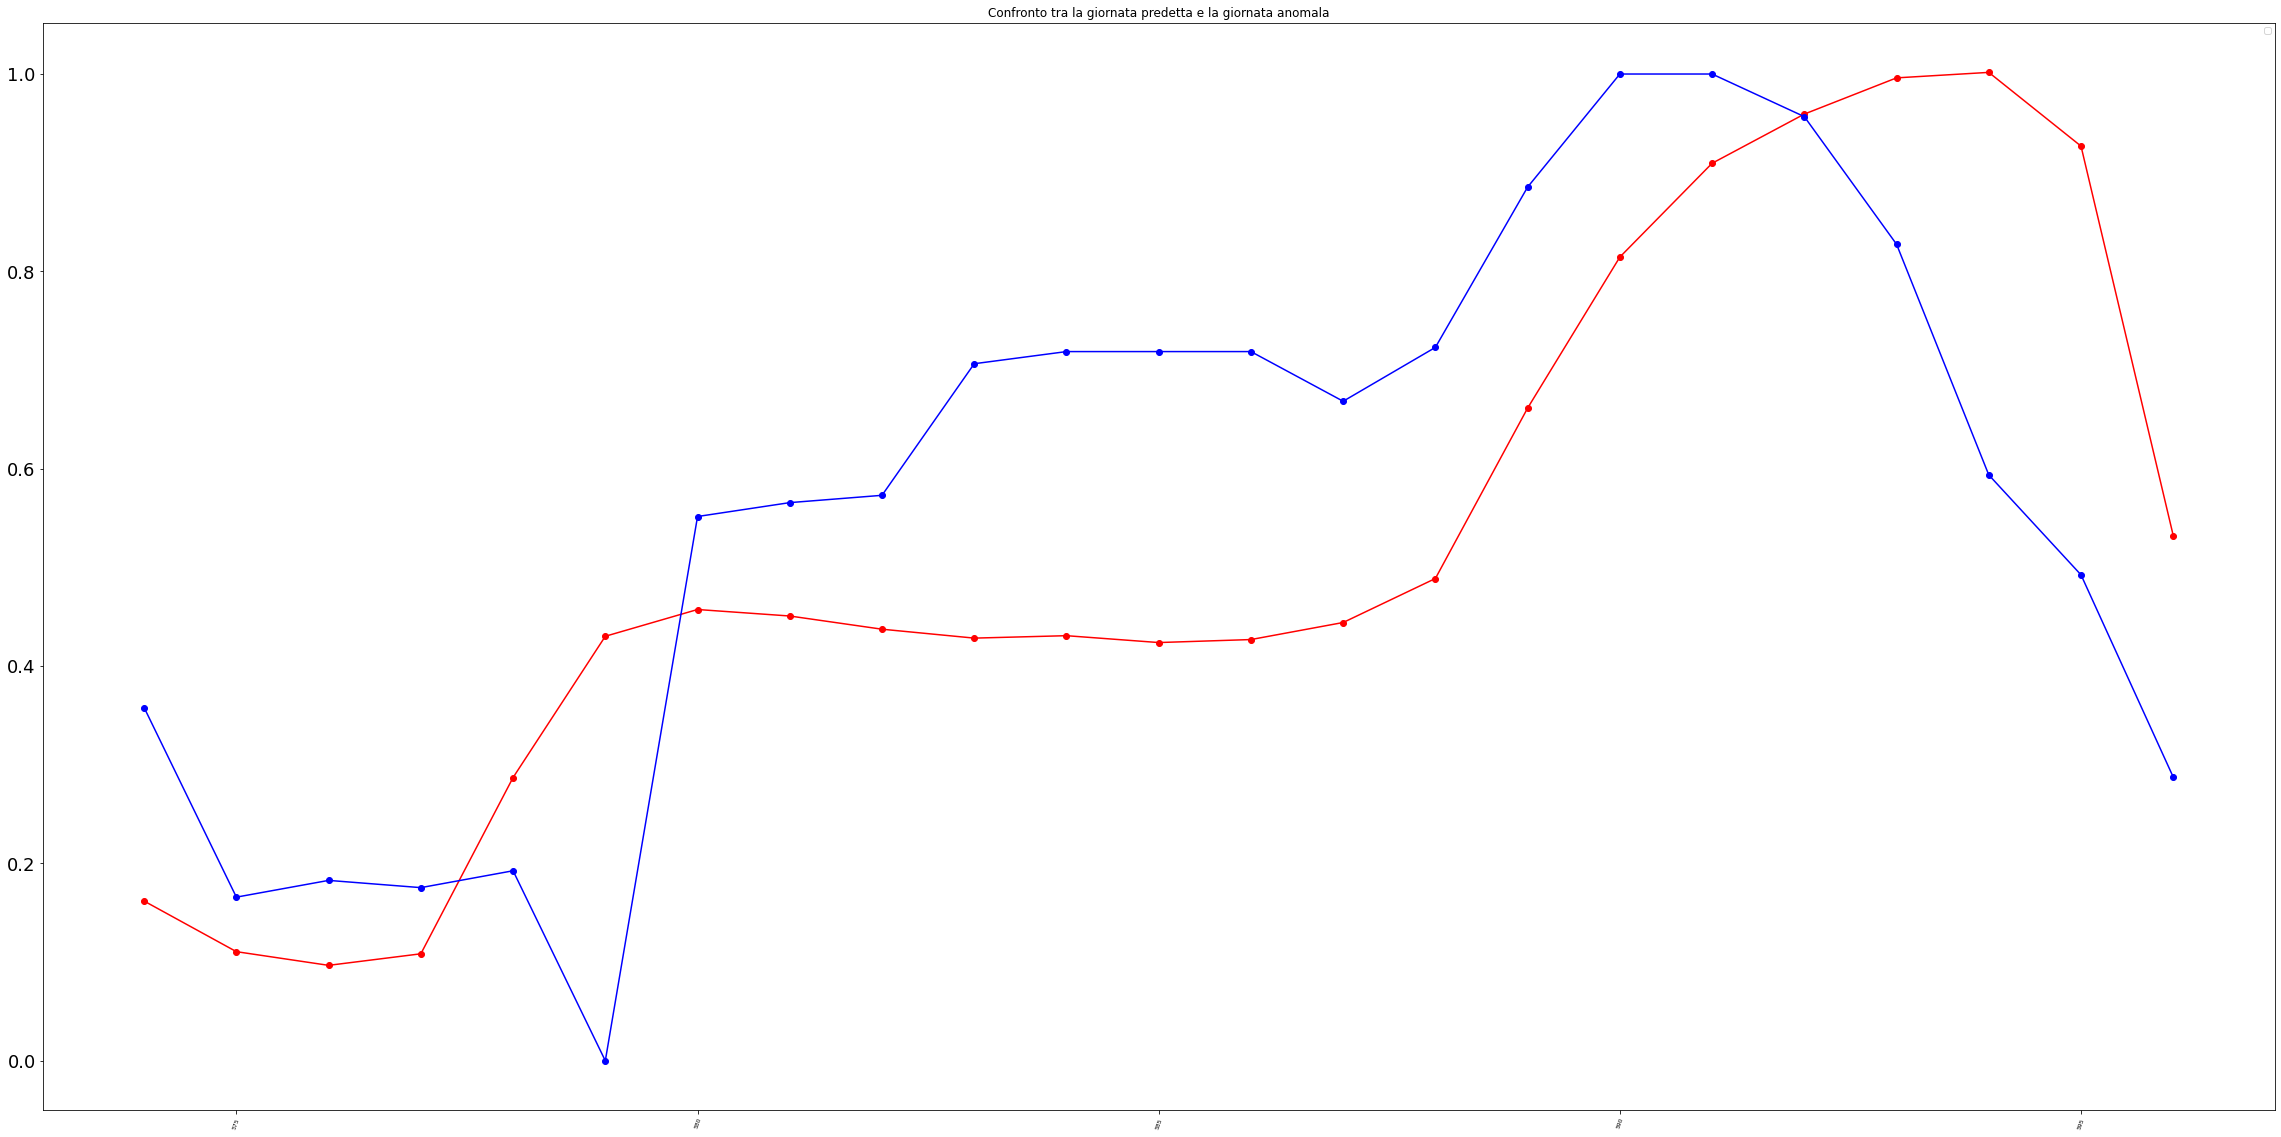

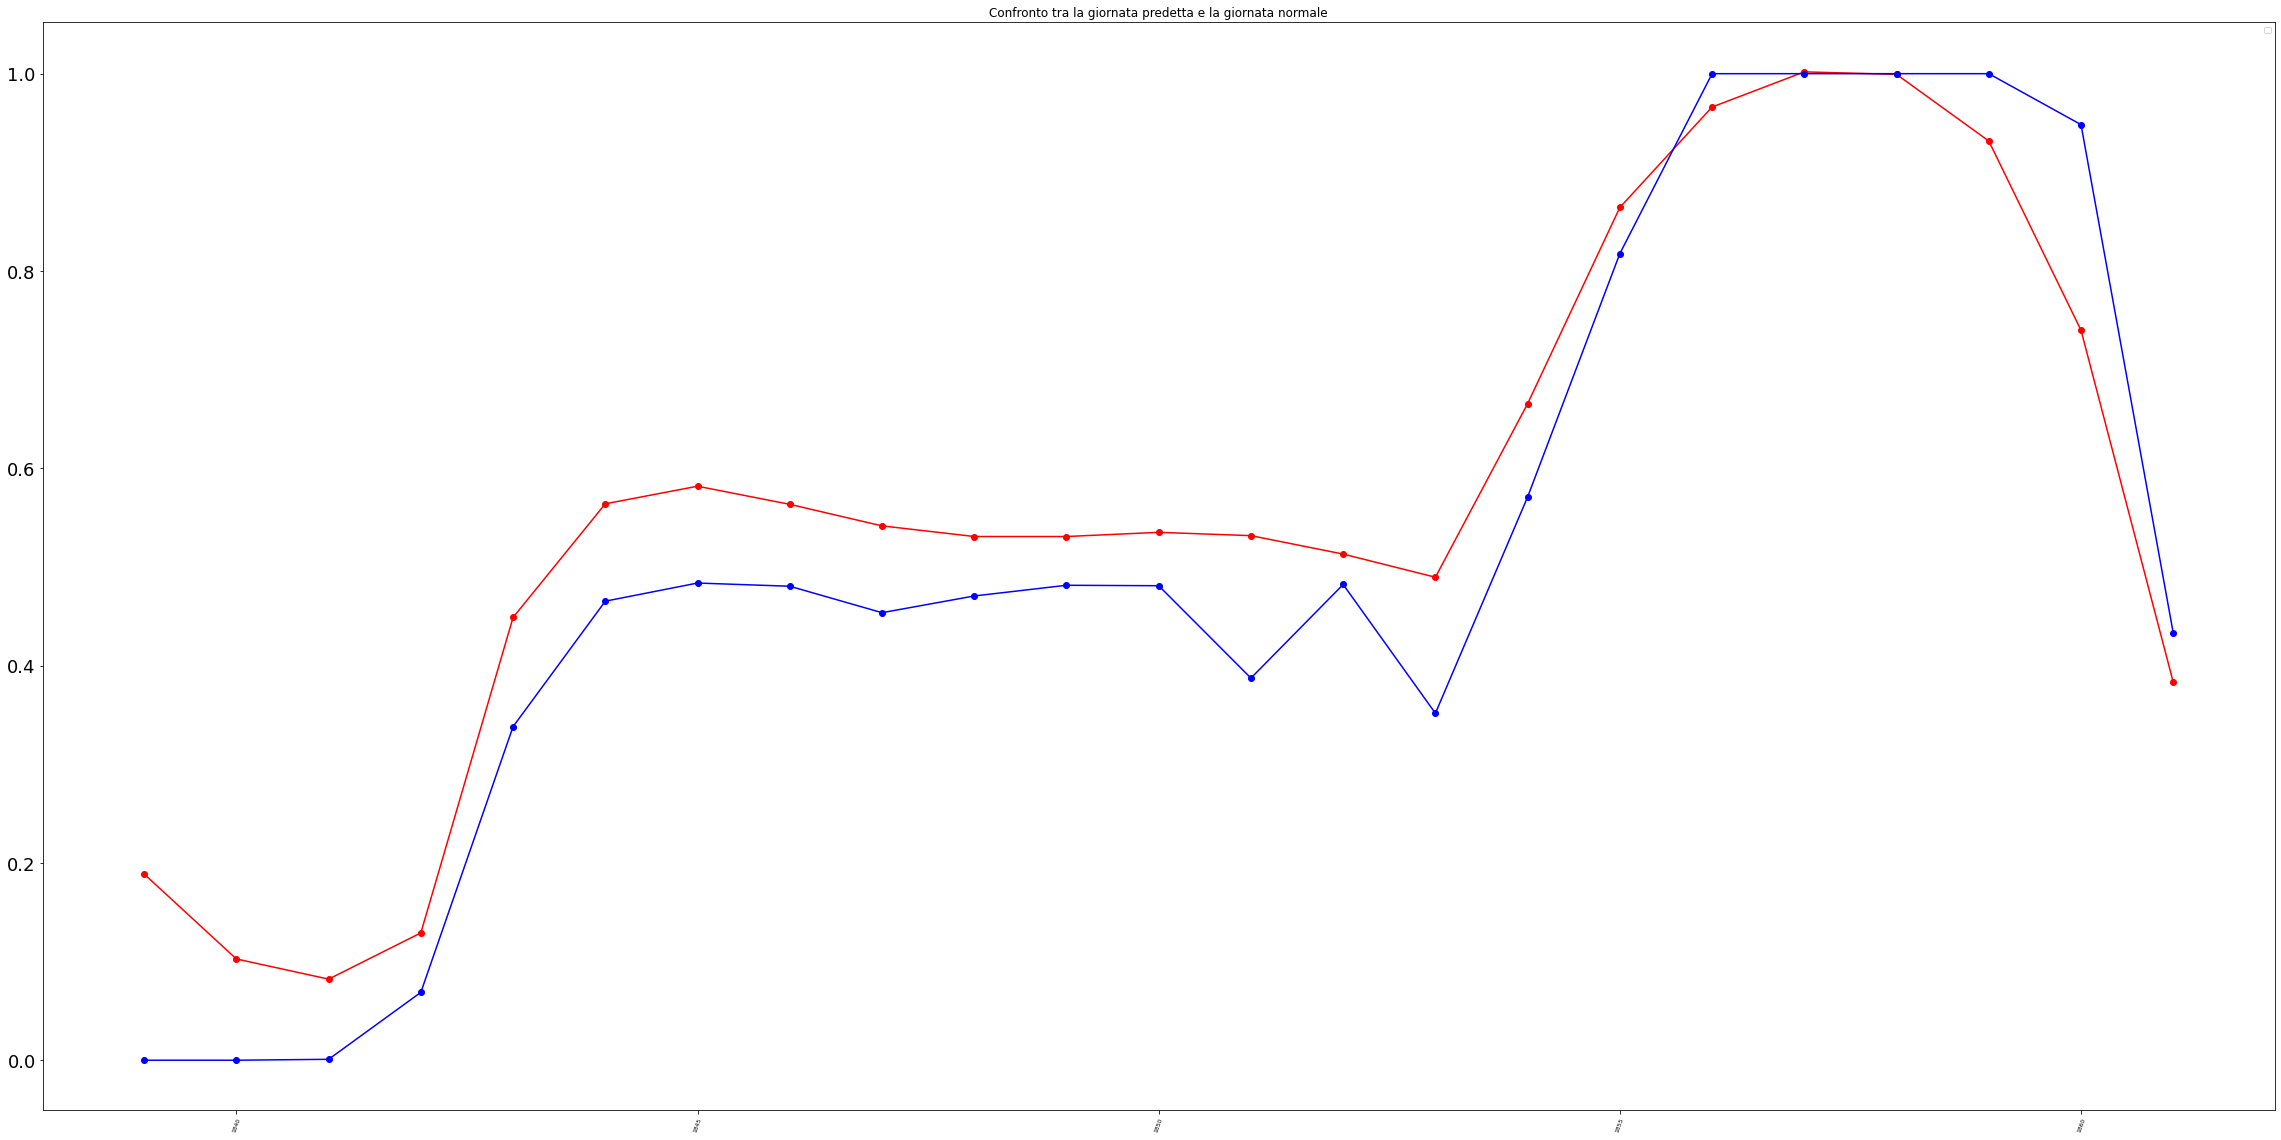

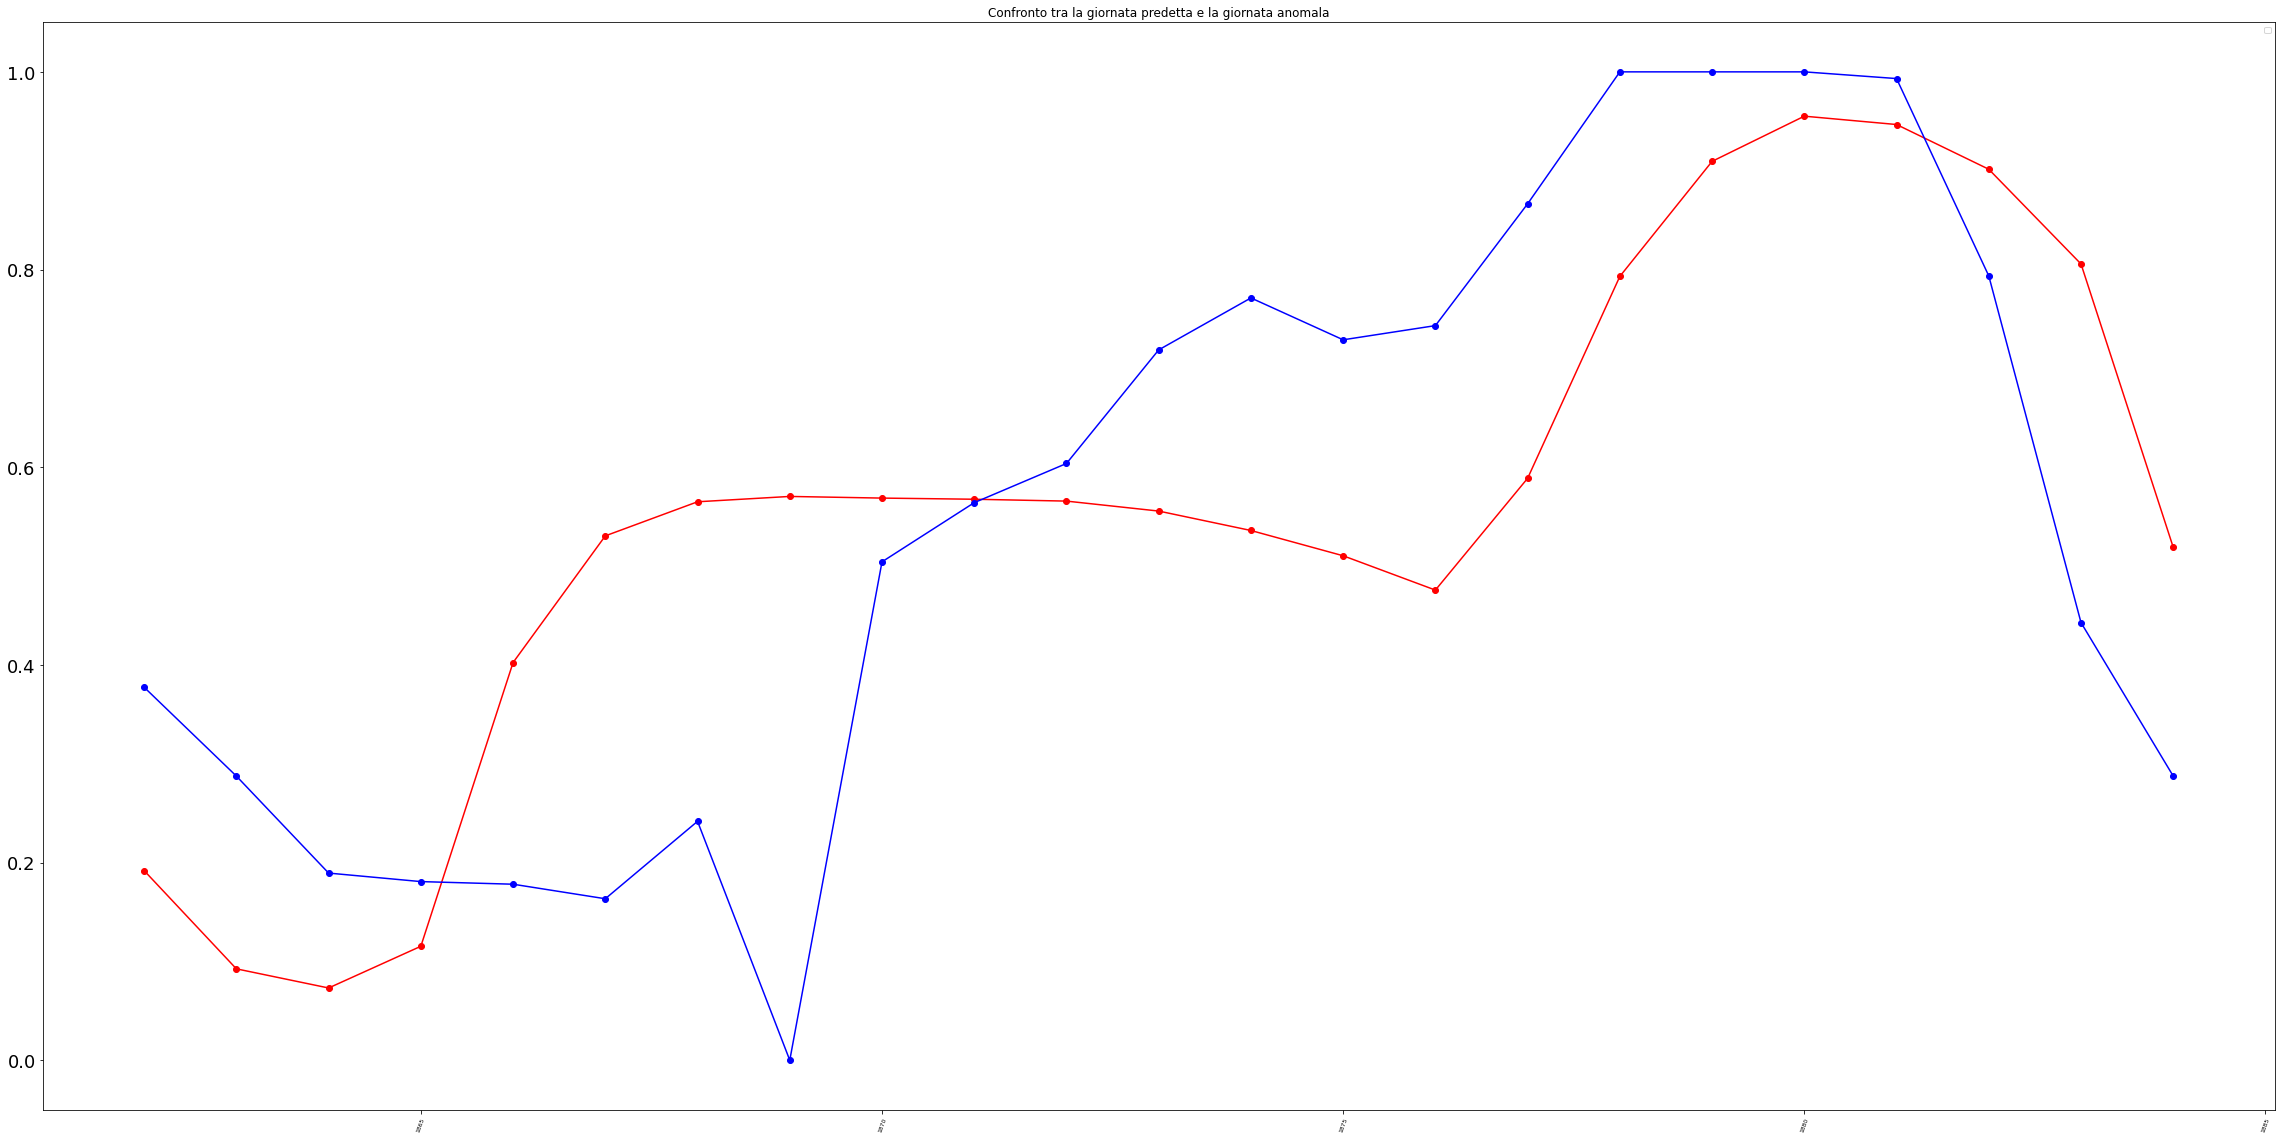

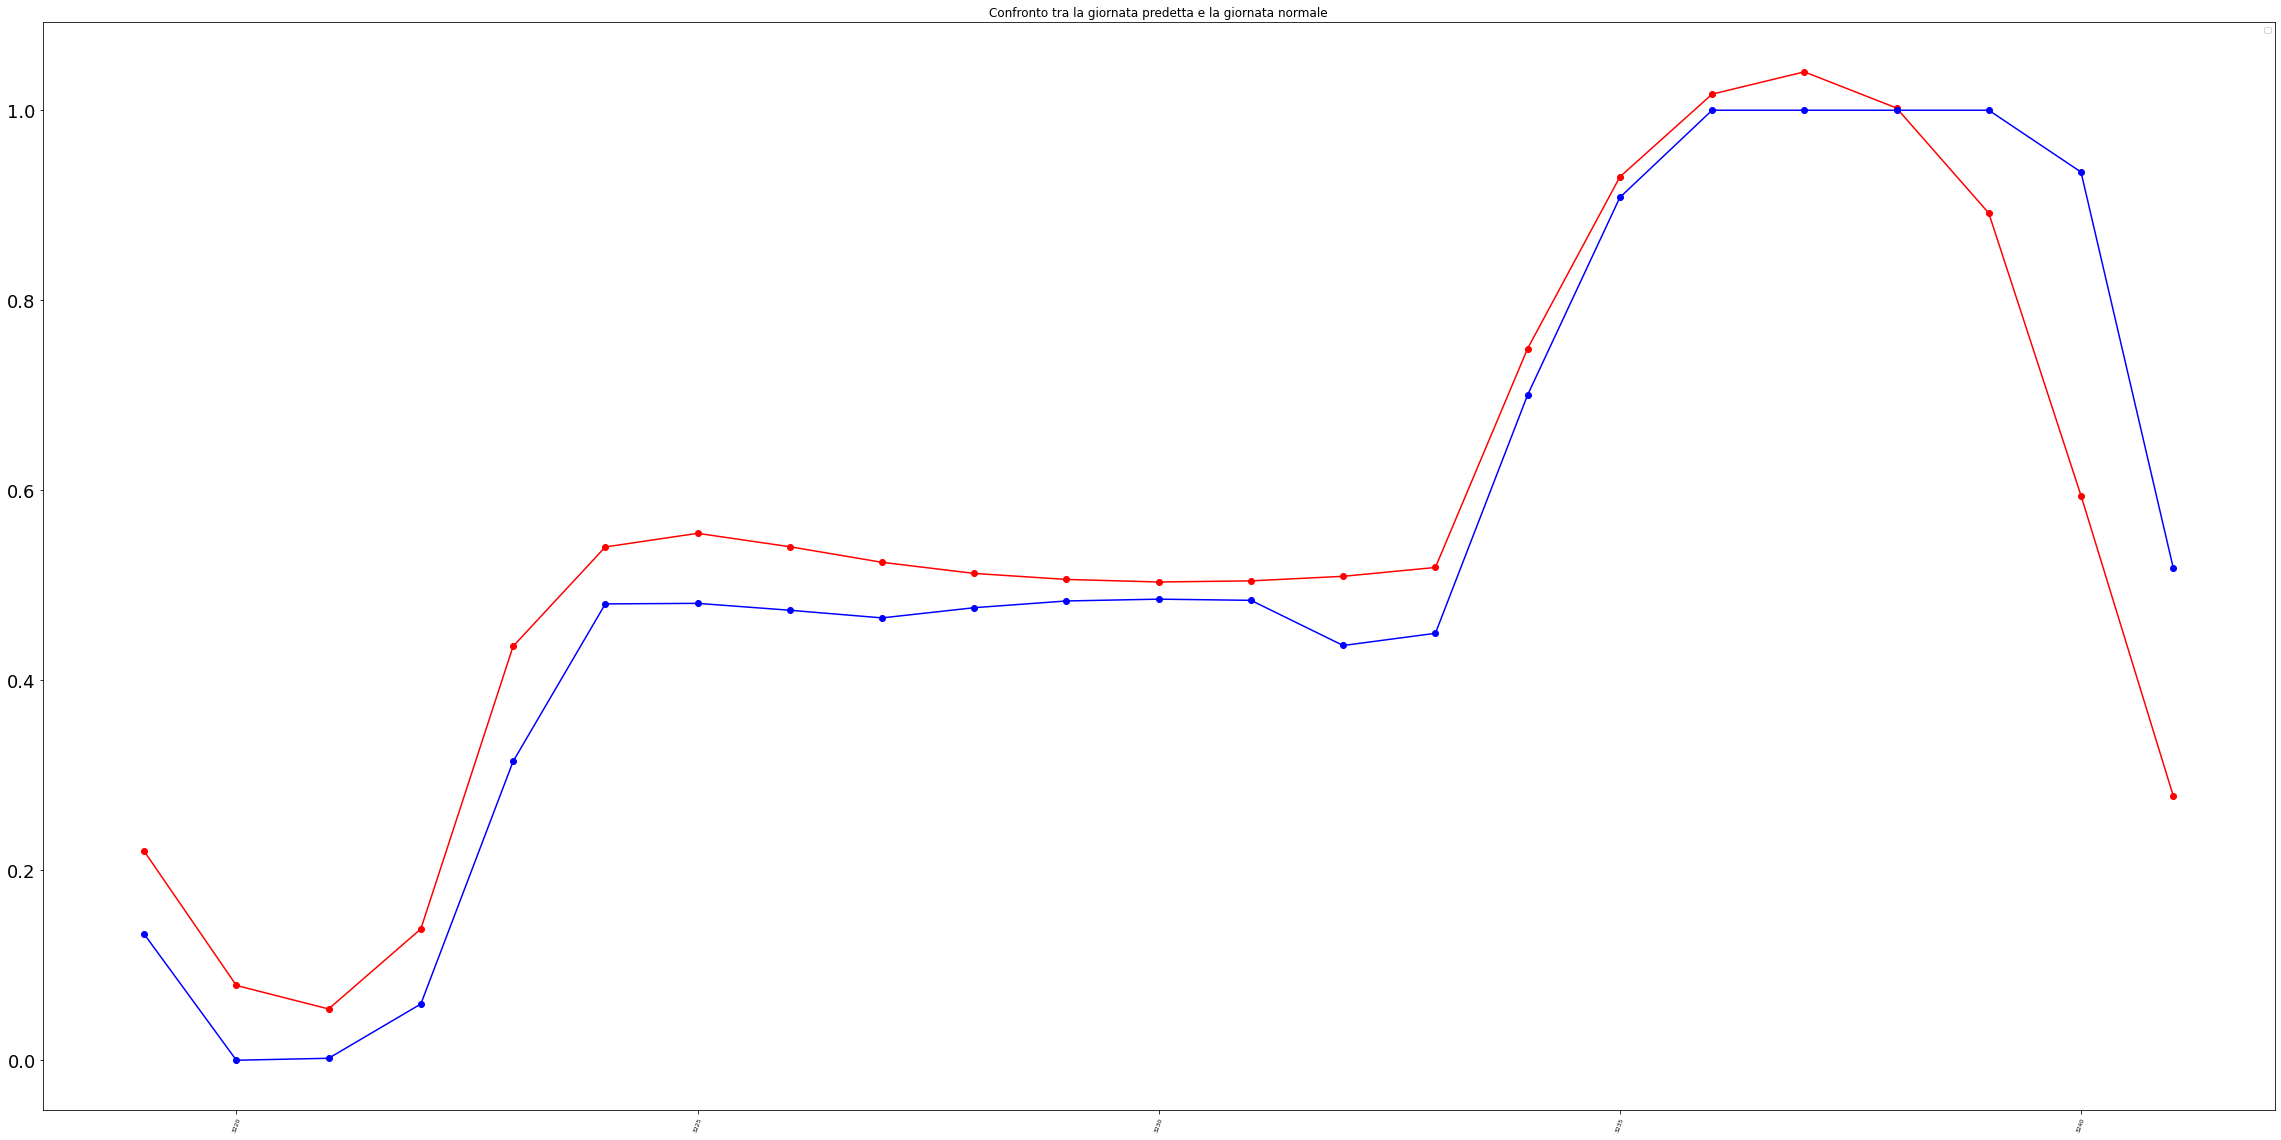

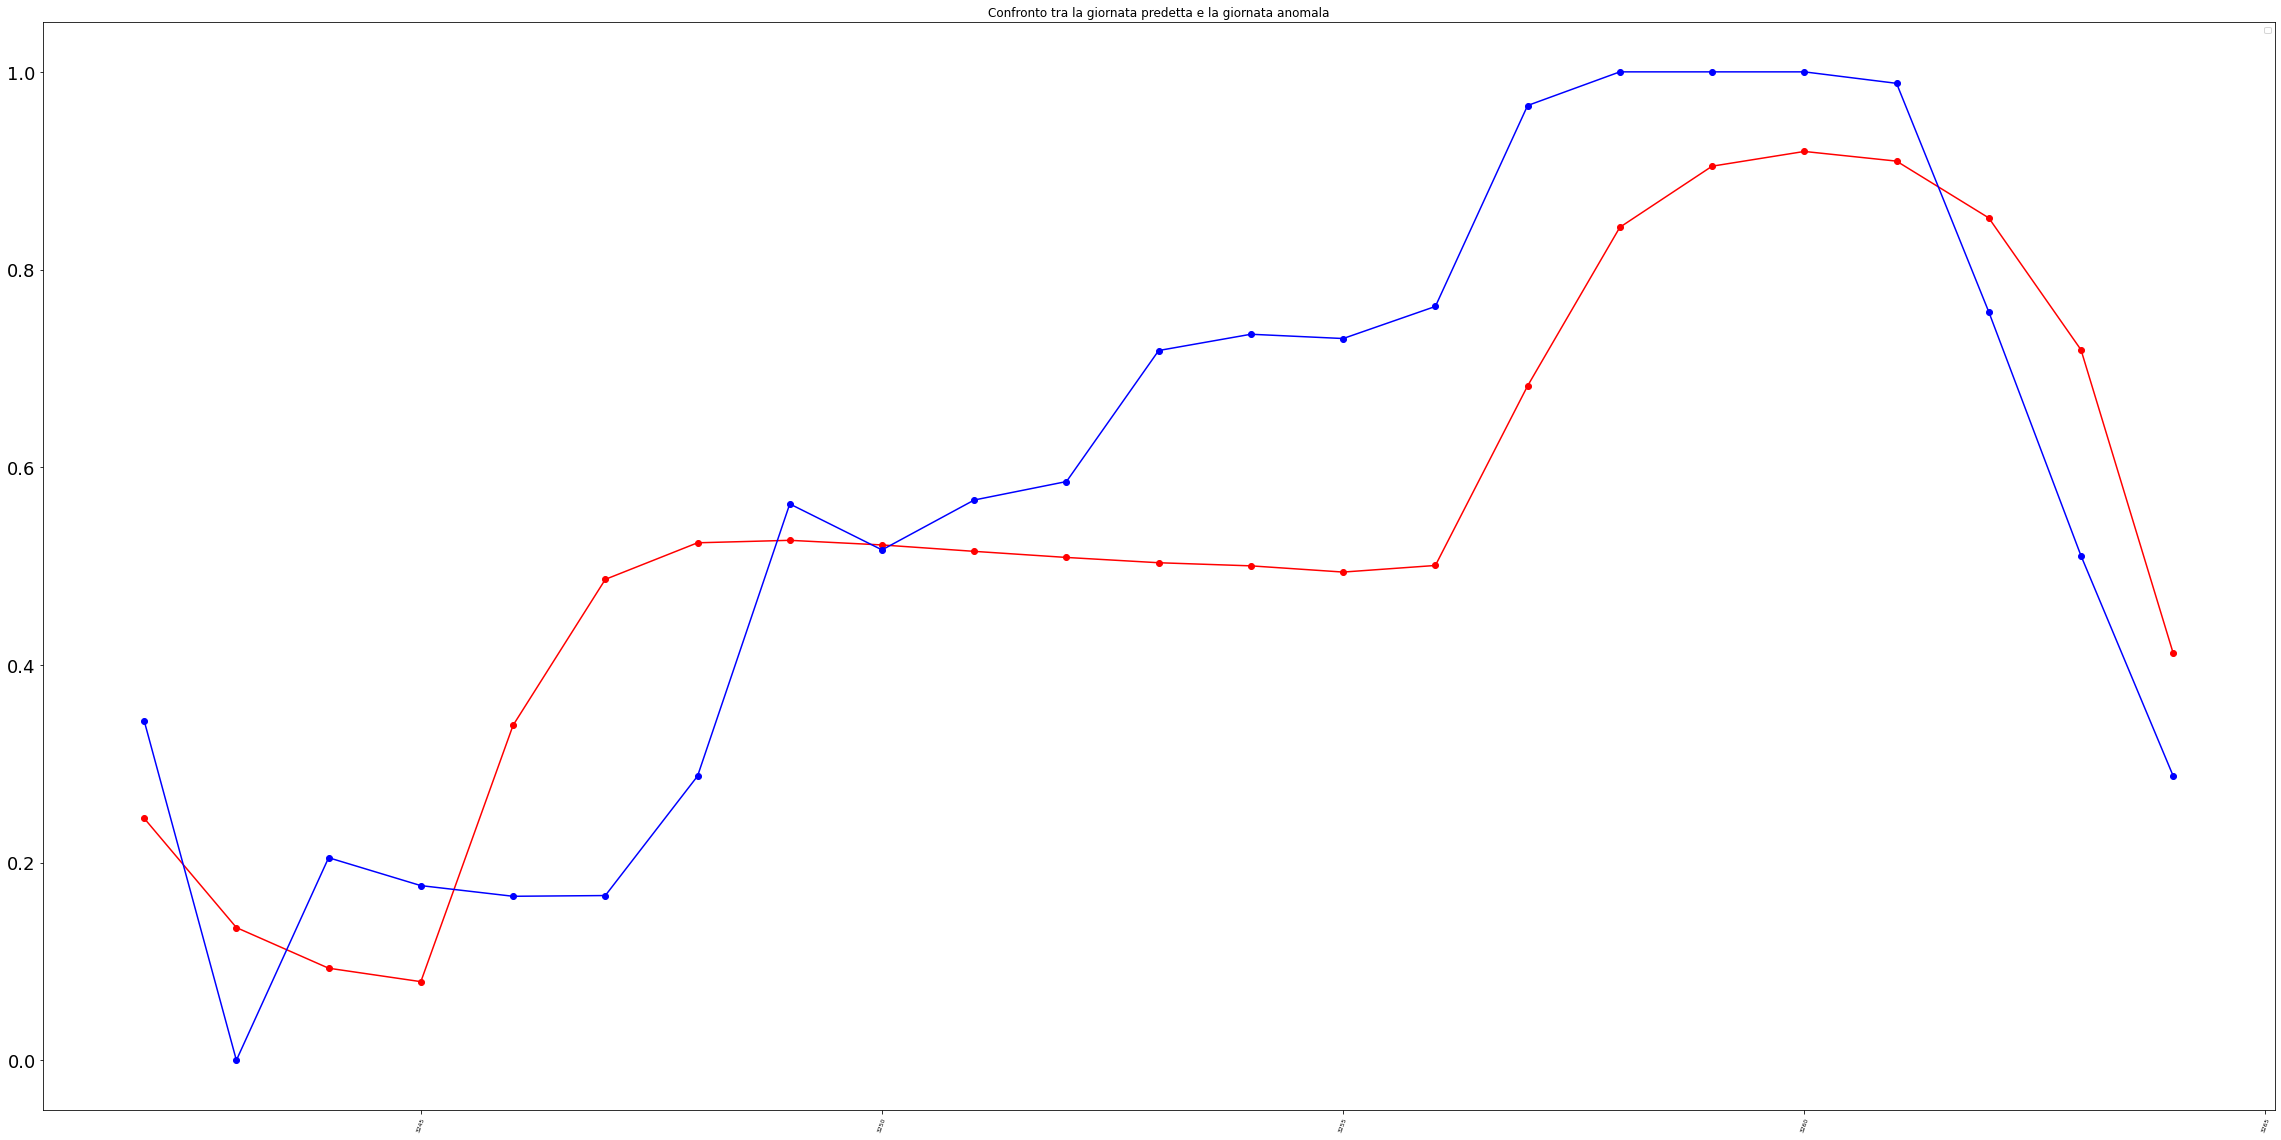

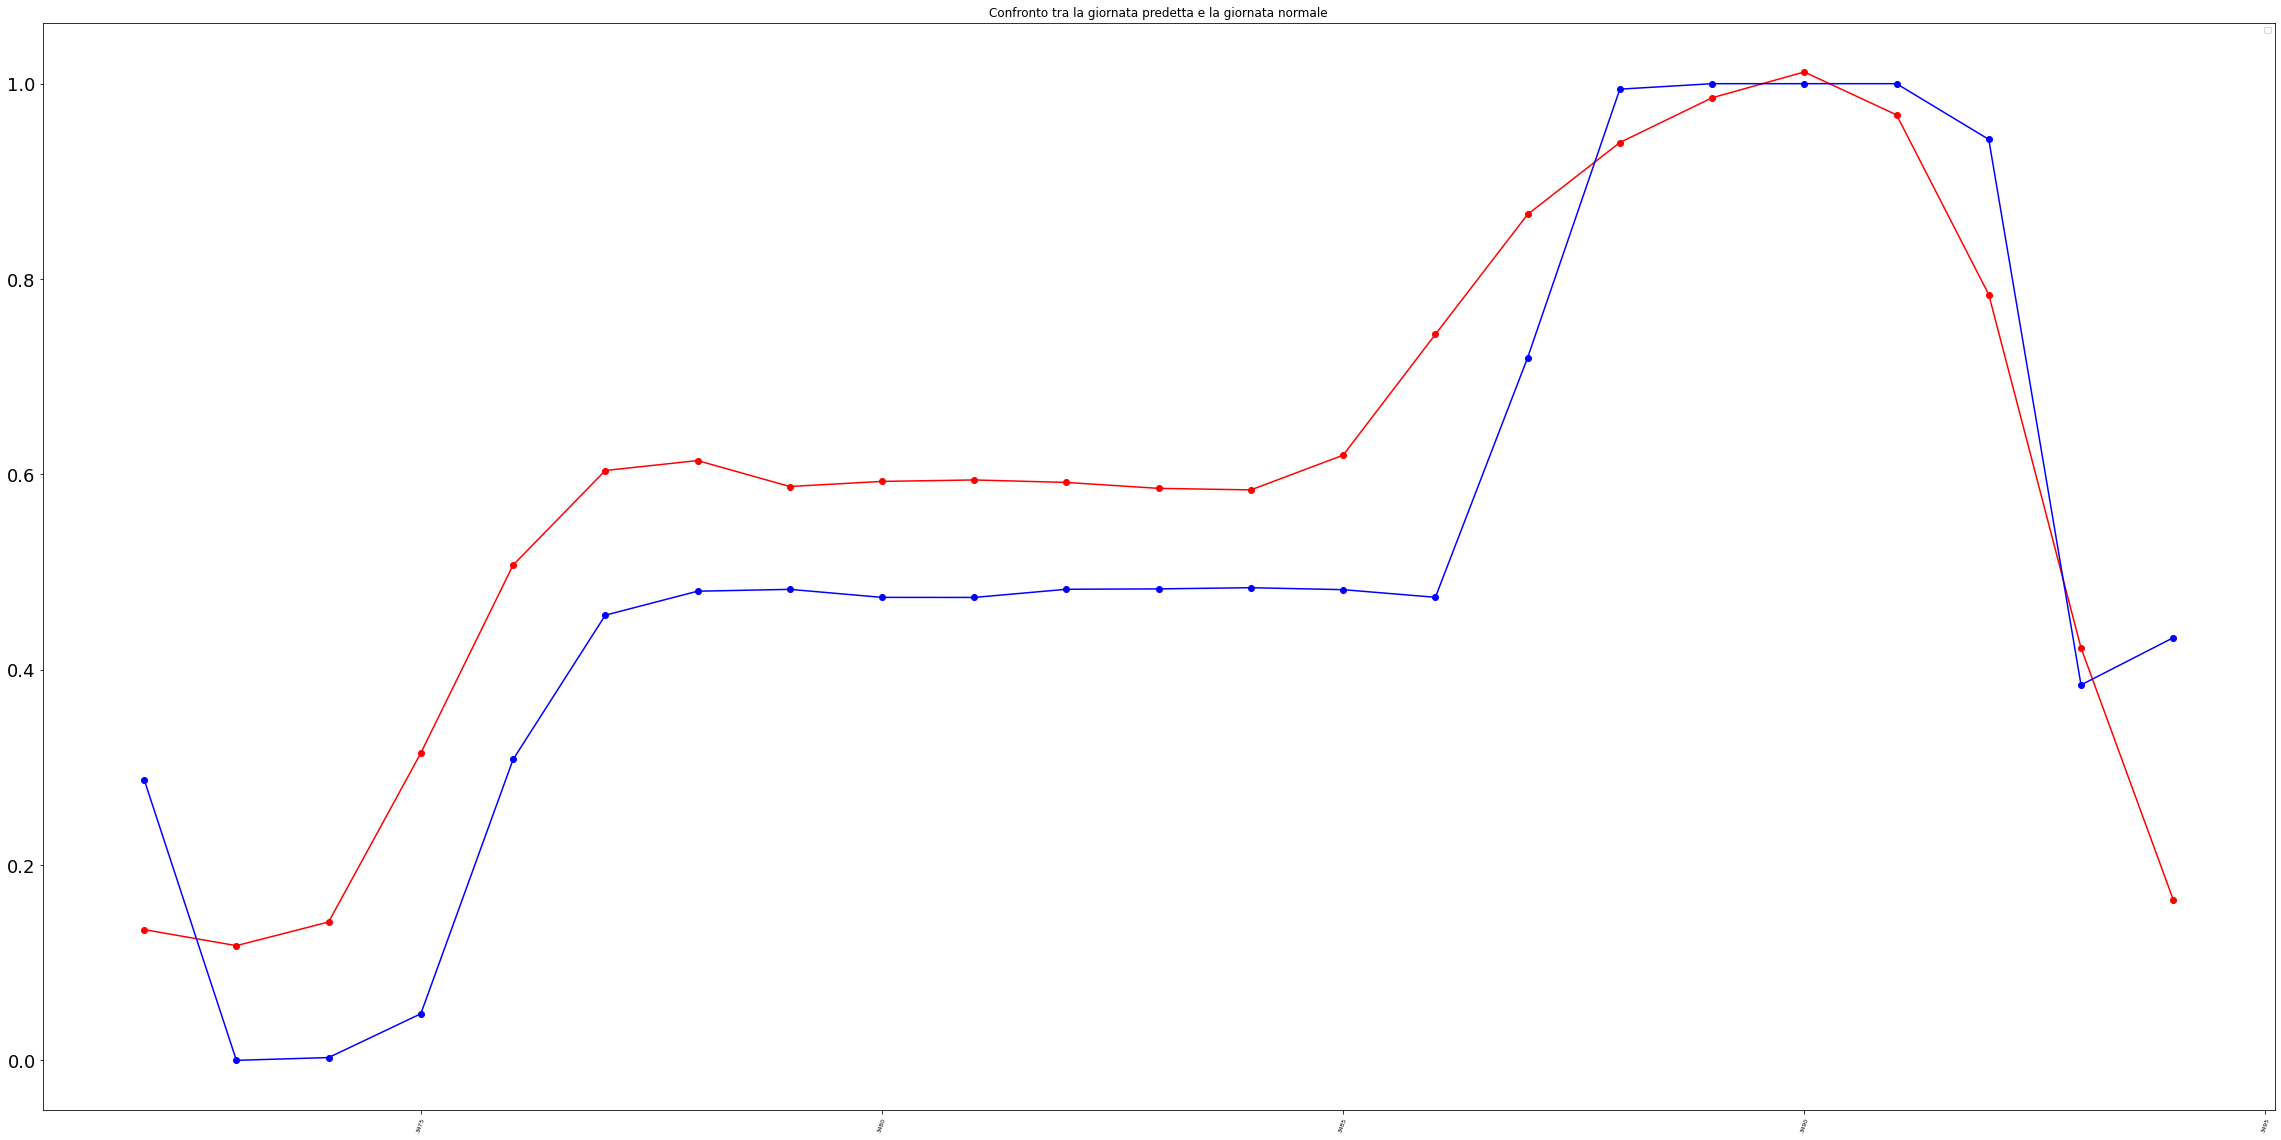

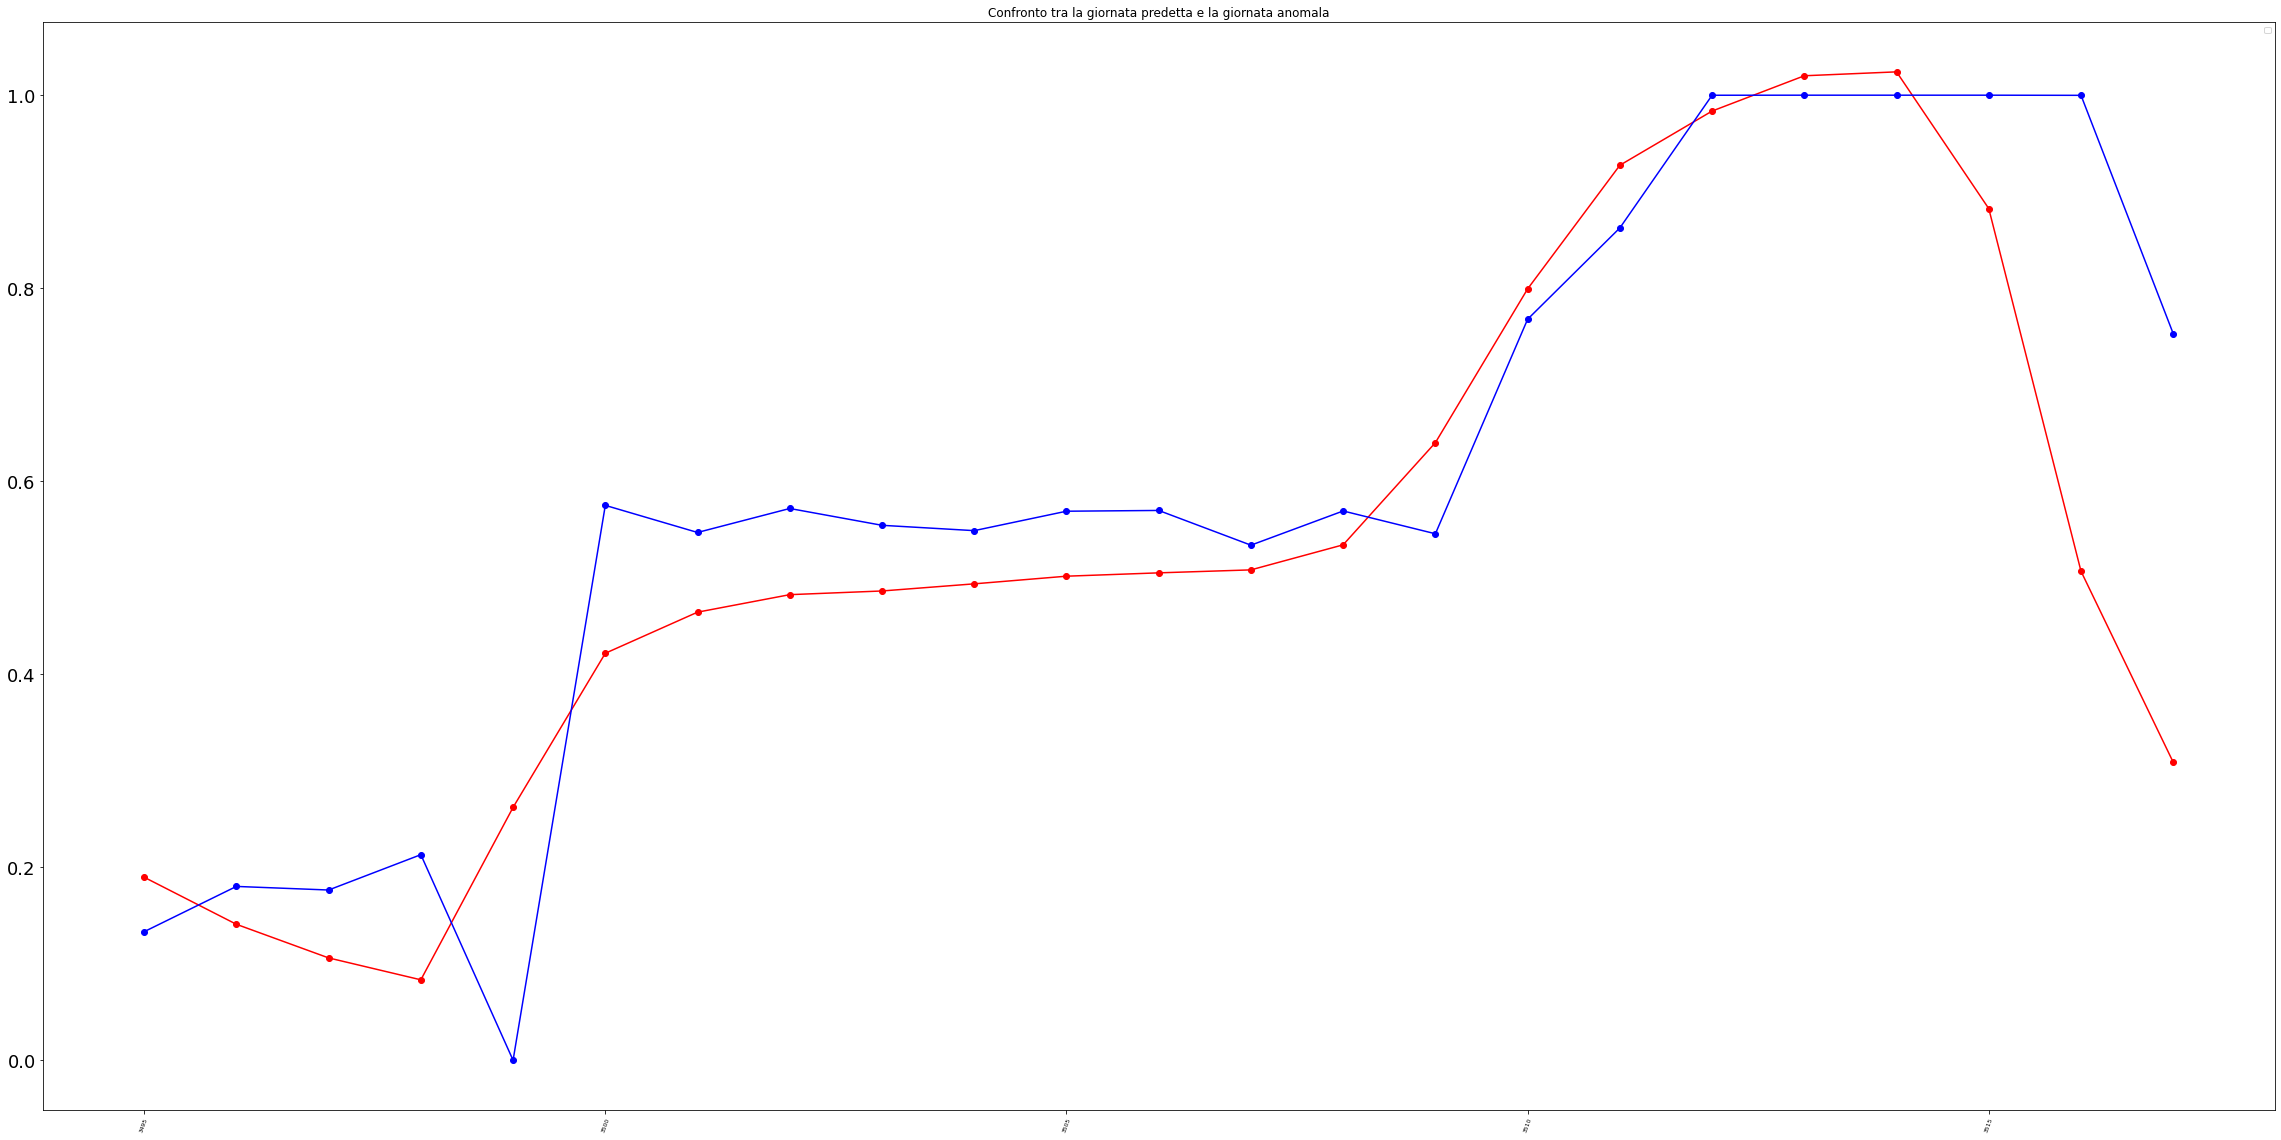

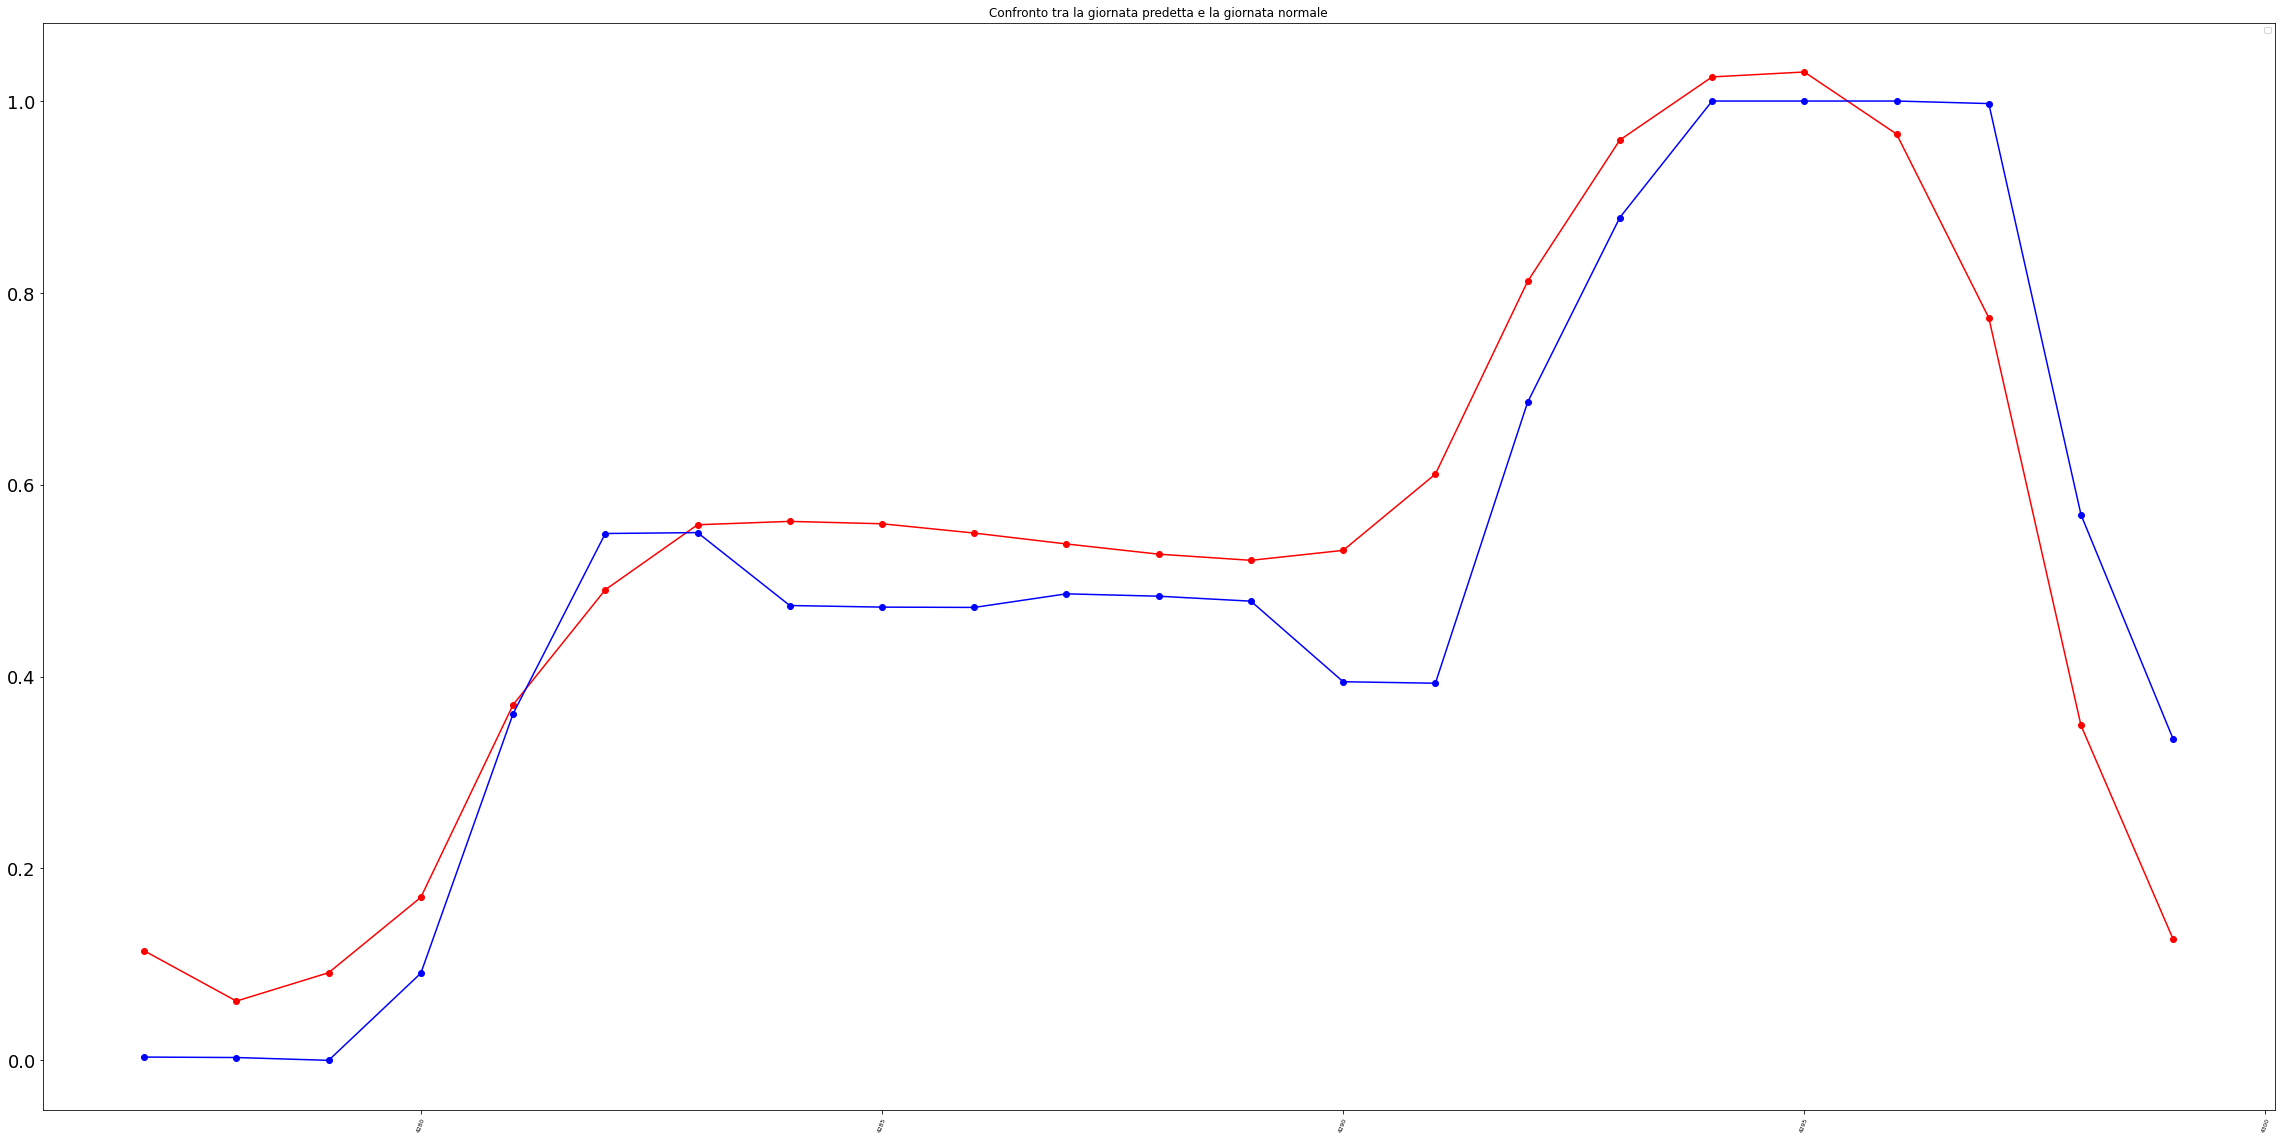

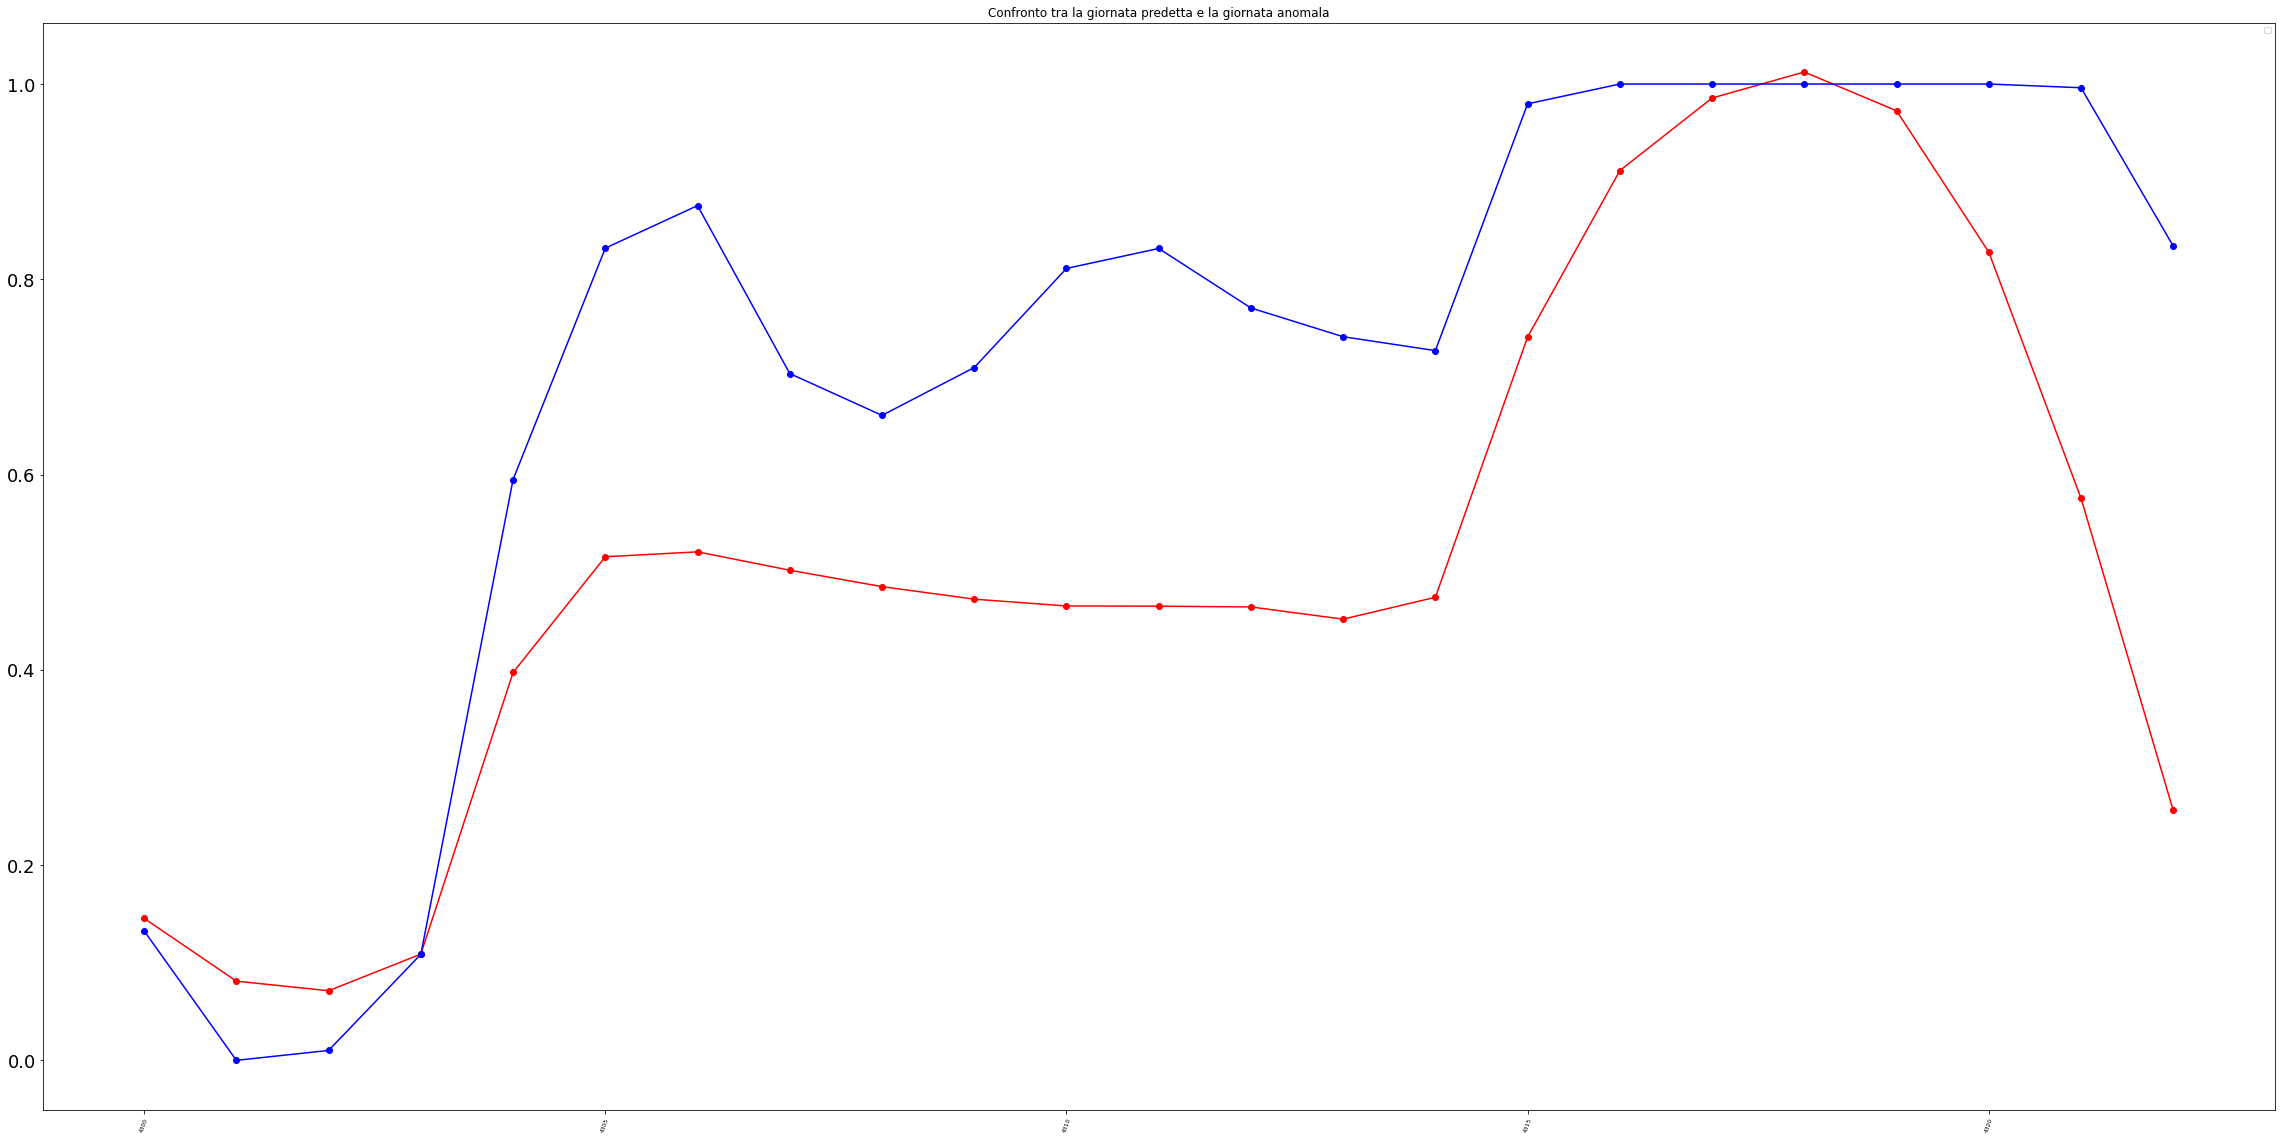

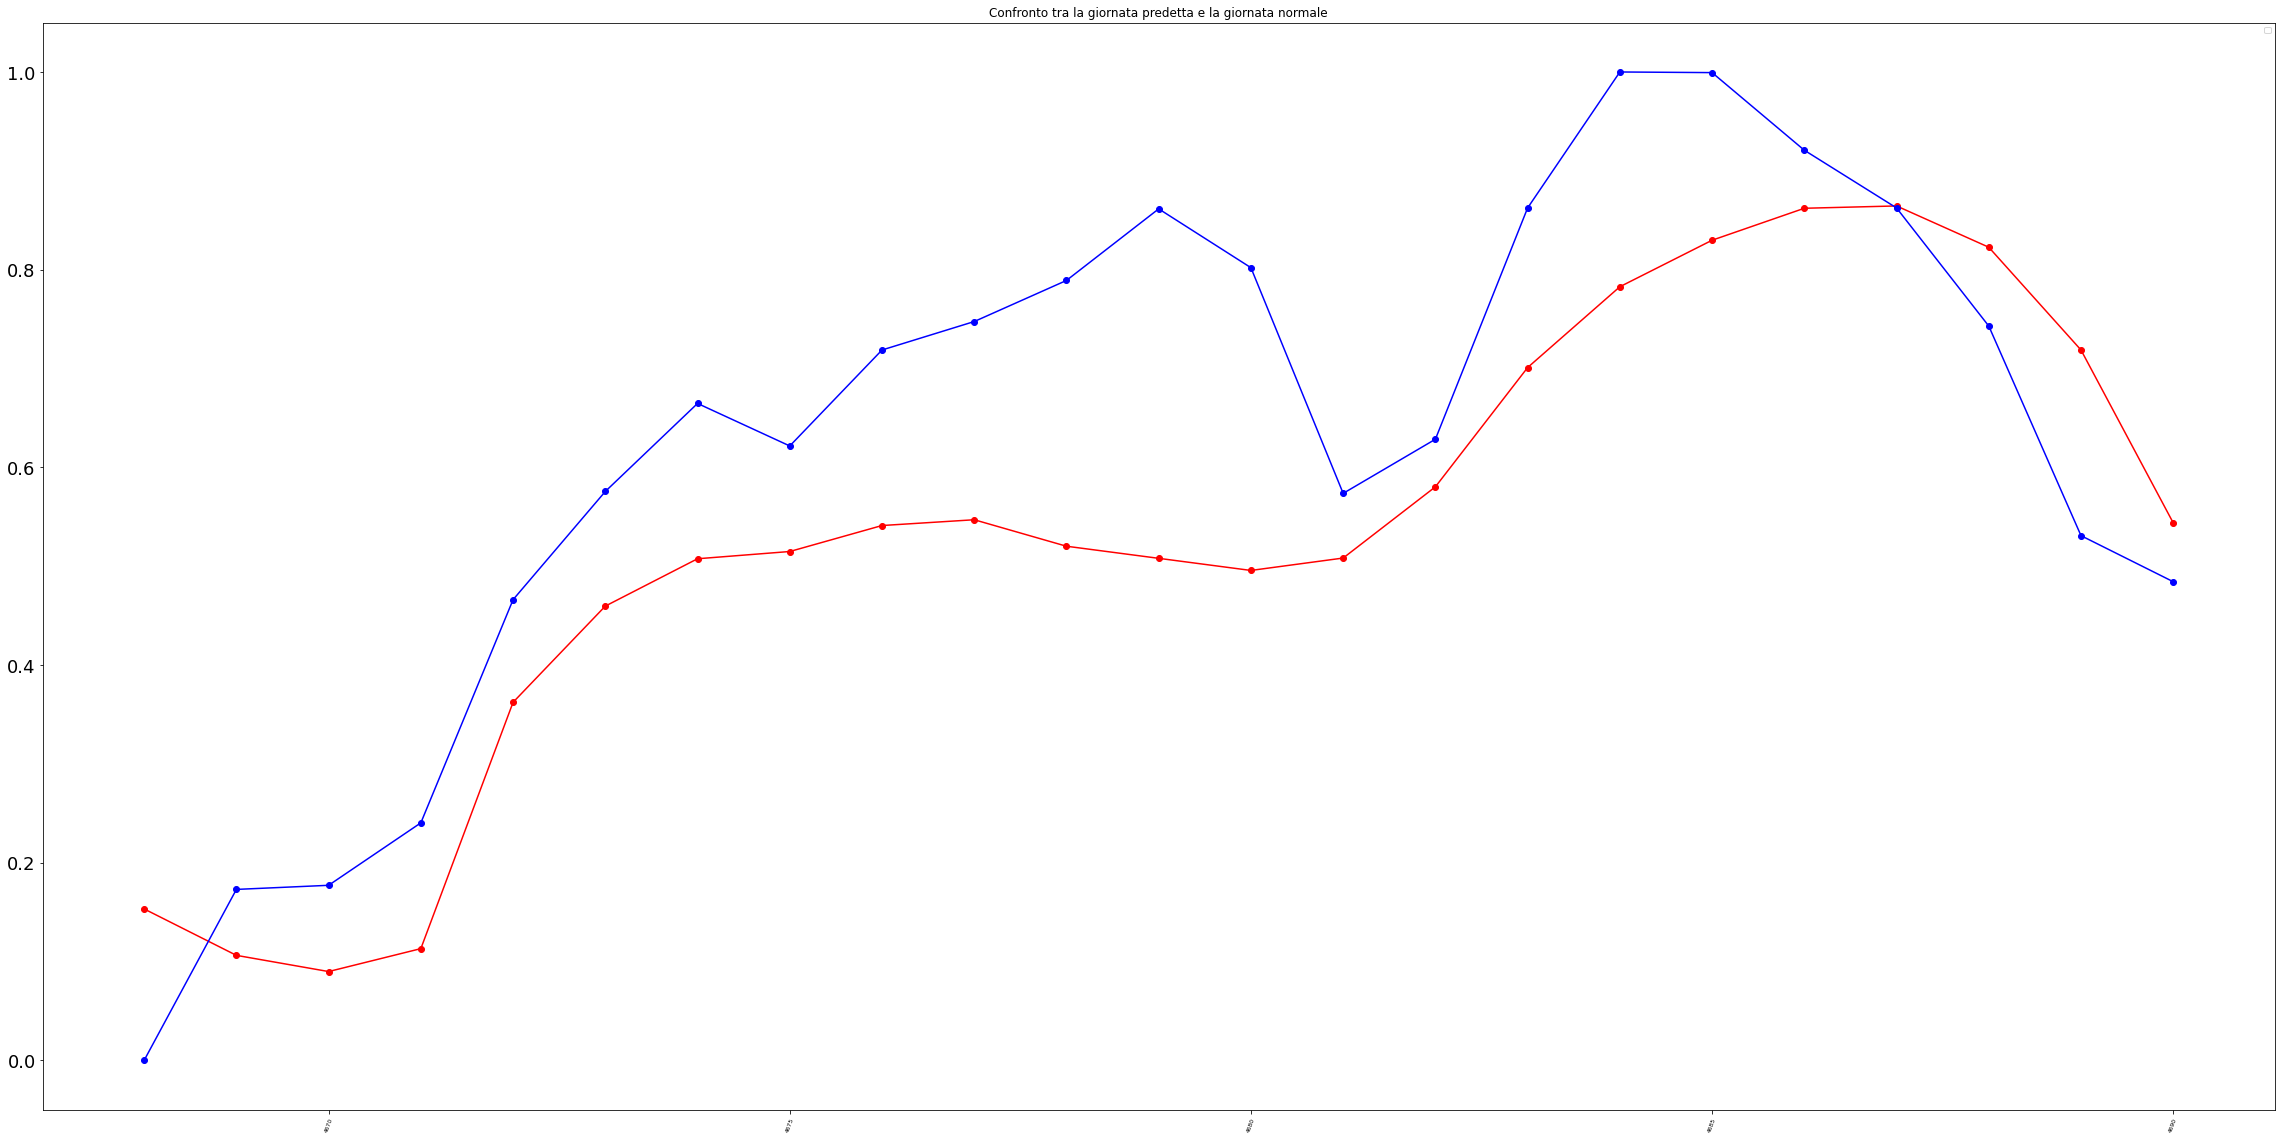

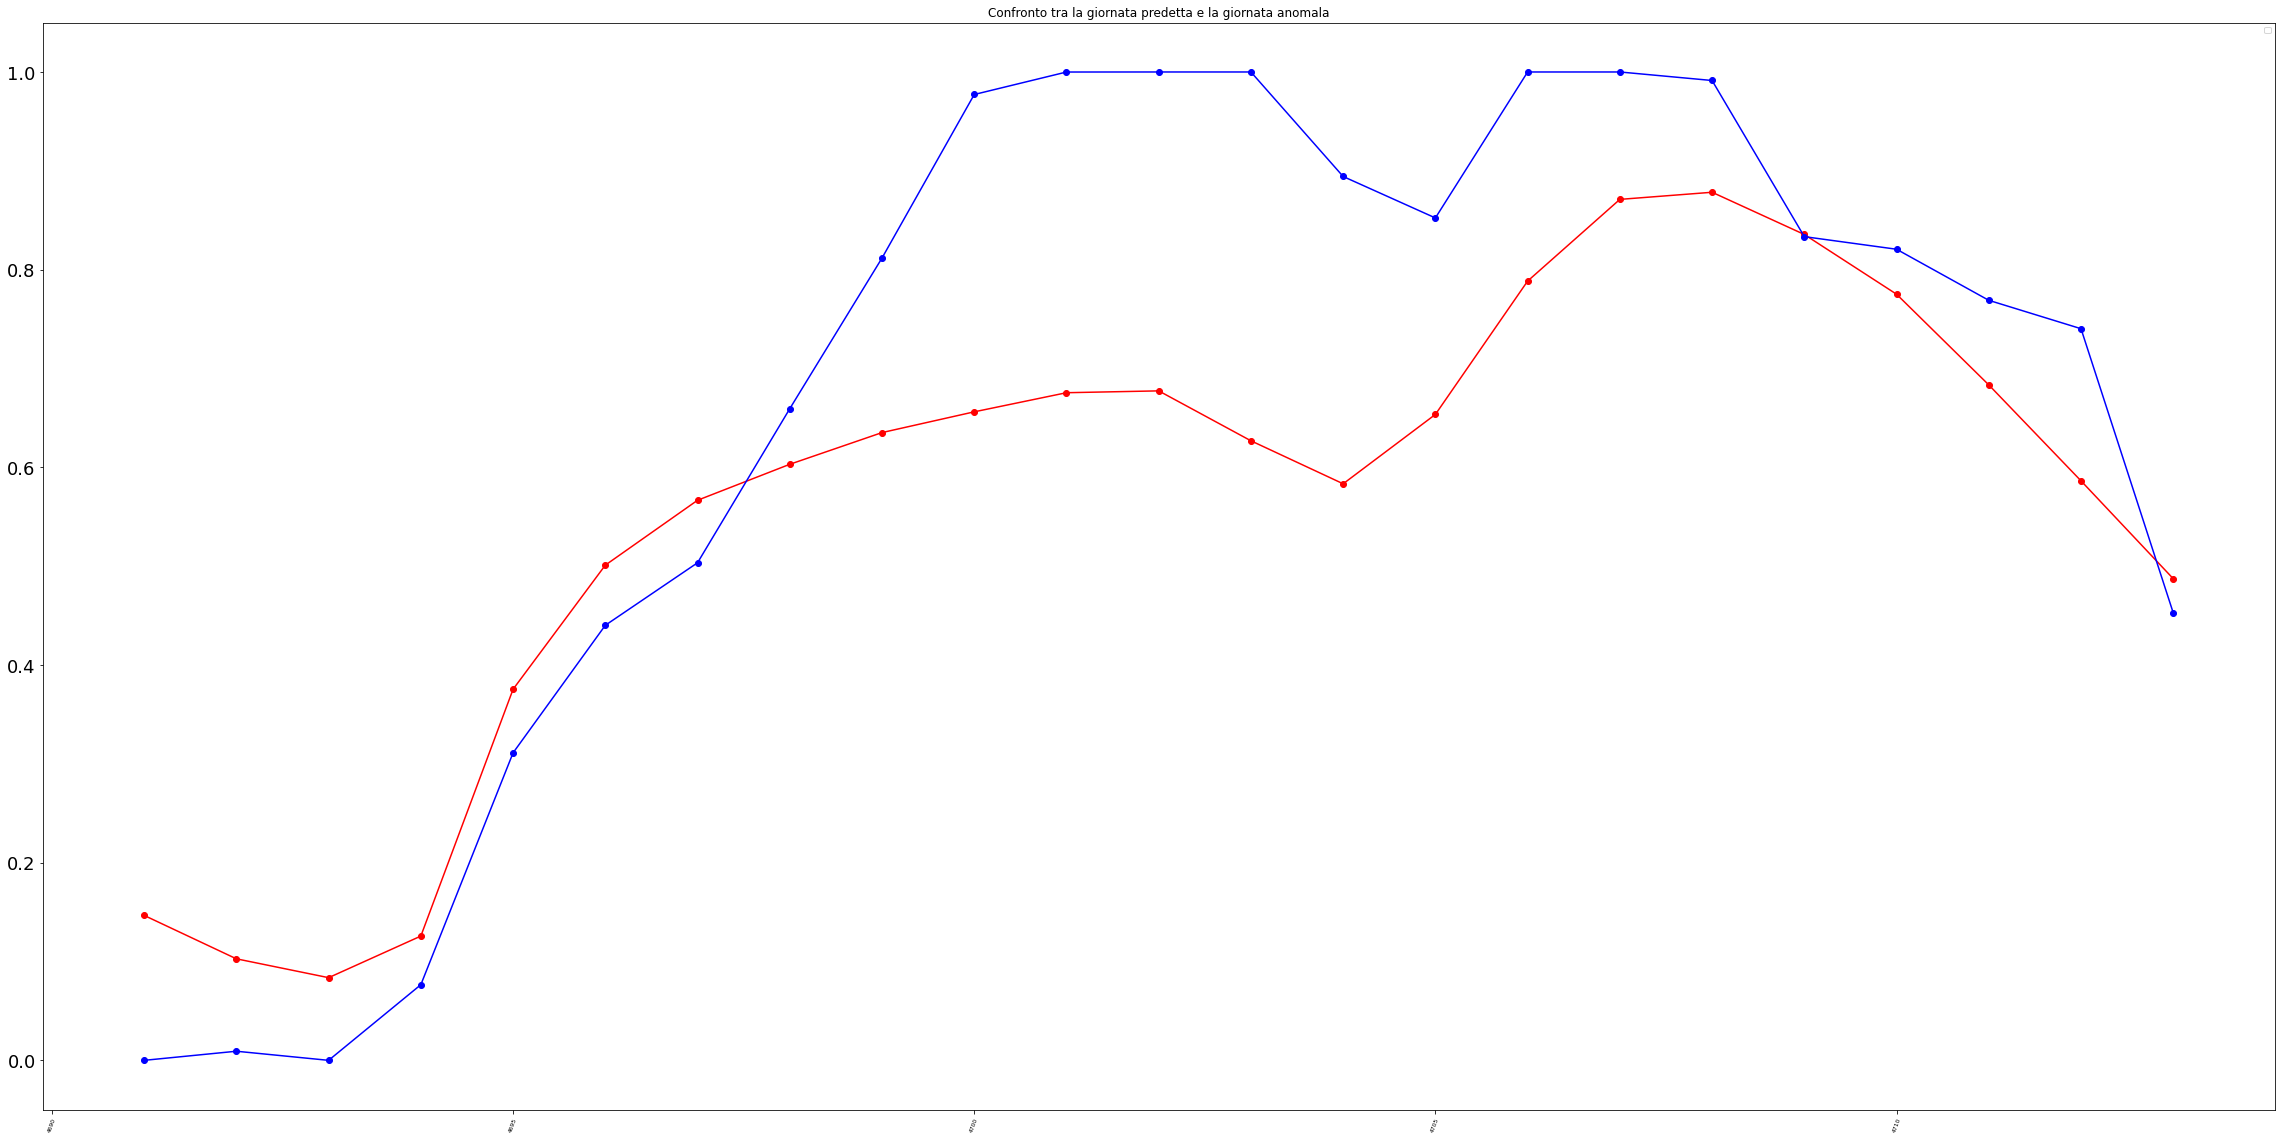

In [94]:
p = Predittore("dati")
d = data_preparation()
n = d.prepare_data("dati_preprocessati.csv")

contatore = 0

for i in range(n):
  with open("dati" + str(i) + ".csv") as f:
    dato = pd.read_csv(f,index_col="Unnamed: 0")

    # 22 è il numero medio di giorni consecutivi normali, valore che usiamo come soglia per la dimensione minima della finestra
    # if dato["Finestra"].max() > 22*23:
    # 10 permette di includere 6 giorni anomali su 9
    if dato["Finestra"].max() >= 10*23:
      p.predizione_ultima_giornata_non_anomala(dato,contatore)
      p.predizione_giornata_anomala(dato,contatore)

    contatore += 1


In [97]:
c = classifier()
c.classify_data(p)

0.8333333333333334
     Cosine distance  Anomali_reali  Anomali_predetti
25          0.030397              0                 1
26          0.070386              1                 1
81          0.011989              0                 0
82          0.069395              1                 0
141         0.014637              0                 0
142         0.033675              1                 1
152         0.025027              0                 0
153         0.029175              1                 1
187         0.017386              0                 0
188         0.031464              1                 1
204         0.020817              0                 0
205         0.016682              1                 1
